In [19]:
import pandas as pd
import scipy.stats as stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

In [20]:
import warnings
warnings.filterwarnings("ignore")

# Goals
Based on Zillow's need to increase their Zillow Zestimate, I am working to create a linear regressionmodel that can 
more accurately predict the logerror, or difference between the Zestimate and the actual sale price of the home.  
Based on this, my initial data set will only be those that include an available logerror.  I will train multiple
models in order to find a model that best works based on a lower MSE total.

# Data Acquisition

In [21]:
props_2016 = pd.read_csv('properties_2016.csv')
props_2016.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [22]:
log_error_2016 = pd.read_csv('train_2016_v2.csv')
log_error_2016.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [23]:
zillow_all = pd.merge(props_2016, log_error_2016, on=['parcelid'])
zillow_all.shape

(90275, 60)

In [24]:
zillow = zillow_all.drop(['poolcnt',
    'airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fips',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'roomcnt',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'numberofstories',
 'fireplaceflag',
 'structuretaxvaluedollarcnt',
 'assessmentyear',
 'landtaxvaluedollarcnt',
 'taxamount',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'censustractandblock',
 'transactiondate'], axis=1)
zillow.shape

(90275, 10)

In [25]:
zillow.isnull().sum()

parcelid                            0
bathroomcnt                         0
bedroomcnt                          0
calculatedfinishedsquarefeet      661
lotsizesquarefeet               10150
regionidzip                        35
unitcnt                         31922
yearbuilt                         756
taxvaluedollarcnt                   1
logerror                            0
dtype: int64

# Data Prep

In [26]:
zillow.loc[(zillow['bedroomcnt'] == 0.0) &\
                             (zillow['bathroomcnt'] == 0.0) &\
                             (zillow['bedroomcnt'] == 0.0) &\
                             (zillow['calculatedfinishedsquarefeet'] > 0.0)]

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,regionidzip,unitcnt,yearbuilt,taxvaluedollarcnt,logerror
123,11683467,0.0,0.0,2290.0,300987.0,96116.0,NaN,1981.0,203396.0,0.2119
227,12658839,0.0,0.0,646.0,976.0,96207.0,2.0,1920.0,556004.0,0.1798
438,17095634,0.0,0.0,1936.0,3996.0,97084.0,NaN,1981.0,227454.0,0.1106
751,14064813,0.0,0.0,3986.0,7842.0,96966.0,4.0,1974.0,480035.0,-0.0377
842,17113854,0.0,0.0,2661.0,17927.0,97083.0,3.0,1947.0,261225.0,0.1354
896,17070642,0.0,0.0,1870.0,6851.0,97081.0,2.0,1952.0,249689.0,0.0488
1184,14018422,0.0,0.0,4442.0,7905.0,97021.0,4.0,1967.0,120282.0,0.0276
1321,17077438,0.0,0.0,1593.0,6500.0,97081.0,2.0,1923.0,143029.0,0.0247
1322,17080870,0.0,0.0,1966.0,5002.0,97083.0,2.0,1960.0,491812.0,0.0296
1339,17184184,0.0,0.0,2068.0,9380.0,97104.0,NaN,1987.0,284612.0,-0.0212


In [27]:
zillow = zillow.drop(zillow[(zillow['bedroomcnt'] == 0.0) & (zillow['bathroomcnt'] == 0.0) &\
                            (zillow['calculatedfinishedsquarefeet'] > 0.0)].index)

In [28]:
zillow.shape

(89784, 10)

In [29]:
zillow.describe()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,regionidzip,unitcnt,yearbuilt,taxvaluedollarcnt,logerror
count,8.978400e+04,89784.000000,89784.00000,89123.000000,7.963800e+04,89751.000000,57951.000000,89054.000000,8.978300e+04,89784.000000
mean,1.297679e+07,2.291940,3.04845,1769.134533,2.913066e+04,96584.797495,1.099308,1968.584578,4.575717e+05,0.011421
std,2.505068e+06,0.992726,1.13759,924.505156,1.195523e+05,3671.143091,0.784244,23.768109,5.553562e+05,0.159787
min,1.071174e+07,0.000000,0.00000,2.000000,1.670000e+02,95982.000000,1.000000,1885.000000,2.200000e+01,-4.605000
25%,1.155534e+07,2.000000,2.00000,1182.000000,5.707000e+03,96193.000000,1.000000,1953.000000,1.990615e+05,-0.025300
50%,1.254417e+07,2.000000,3.00000,1538.000000,7.200000e+03,96389.000000,1.000000,1970.000000,3.428710e+05,0.006000
75%,1.422420e+07,3.000000,4.00000,2090.000000,1.171975e+04,96985.000000,1.000000,1987.000000,5.404490e+05,0.038300
max,1.629608e+08,20.000000,16.00000,22741.000000,6.971010e+06,399675.000000,143.000000,2015.000000,2.775000e+07,4.737000


In [30]:
zillow.isnull().sum()

parcelid                            0
bathroomcnt                         0
bedroomcnt                          0
calculatedfinishedsquarefeet      661
lotsizesquarefeet               10146
regionidzip                        33
unitcnt                         31833
yearbuilt                         730
taxvaluedollarcnt                   1
logerror                            0
dtype: int64

In [79]:
zillow.dtypes

parcelid                          int64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
lotsizesquarefeet               float64
regionidzip                     float64
unitcnt                         float64
yearbuilt                       float64
taxvaluedollarcnt               float64
logerror                        float64
dtype: object

In [31]:
zillow.sort_values(by=['calculatedfinishedsquarefeet']).head(25)

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,regionidzip,unitcnt,yearbuilt,taxvaluedollarcnt,logerror
81433,12660907,3.0,0.0,2.0,10001.0,96123.0,1.0,1980.0,337871.0,0.0440
49230,10825953,20.0,3.0,66.0,6749.0,96414.0,1.0,1960.0,233496.0,-0.0325
14950,10902671,3.0,4.0,120.0,14921.0,96452.0,1.0,1939.0,788975.0,0.0602
32481,11377029,0.0,1.0,120.0,225600.0,97318.0,1.0,1955.0,9271.0,1.3790
85018,12236415,2.0,3.0,152.0,5425.0,96025.0,1.0,1939.0,85122.0,0.0050
15130,12561798,1.0,0.0,199.0,33497.0,96236.0,1.0,1928.0,102553.0,0.1017
25781,11620674,1.0,1.0,214.0,41444.0,96005.0,1.0,1962.0,38246.0,2.9530
55978,11618787,1.0,0.0,230.0,41025.0,96005.0,1.0,1961.0,53011.0,0.7775
33415,11572416,1.0,0.0,242.0,9370.0,96151.0,1.0,1957.0,231952.0,0.0266
20123,14280158,1.0,2.0,257.0,6752.0,96959.0,NaN,1954.0,810000.0,0.0998


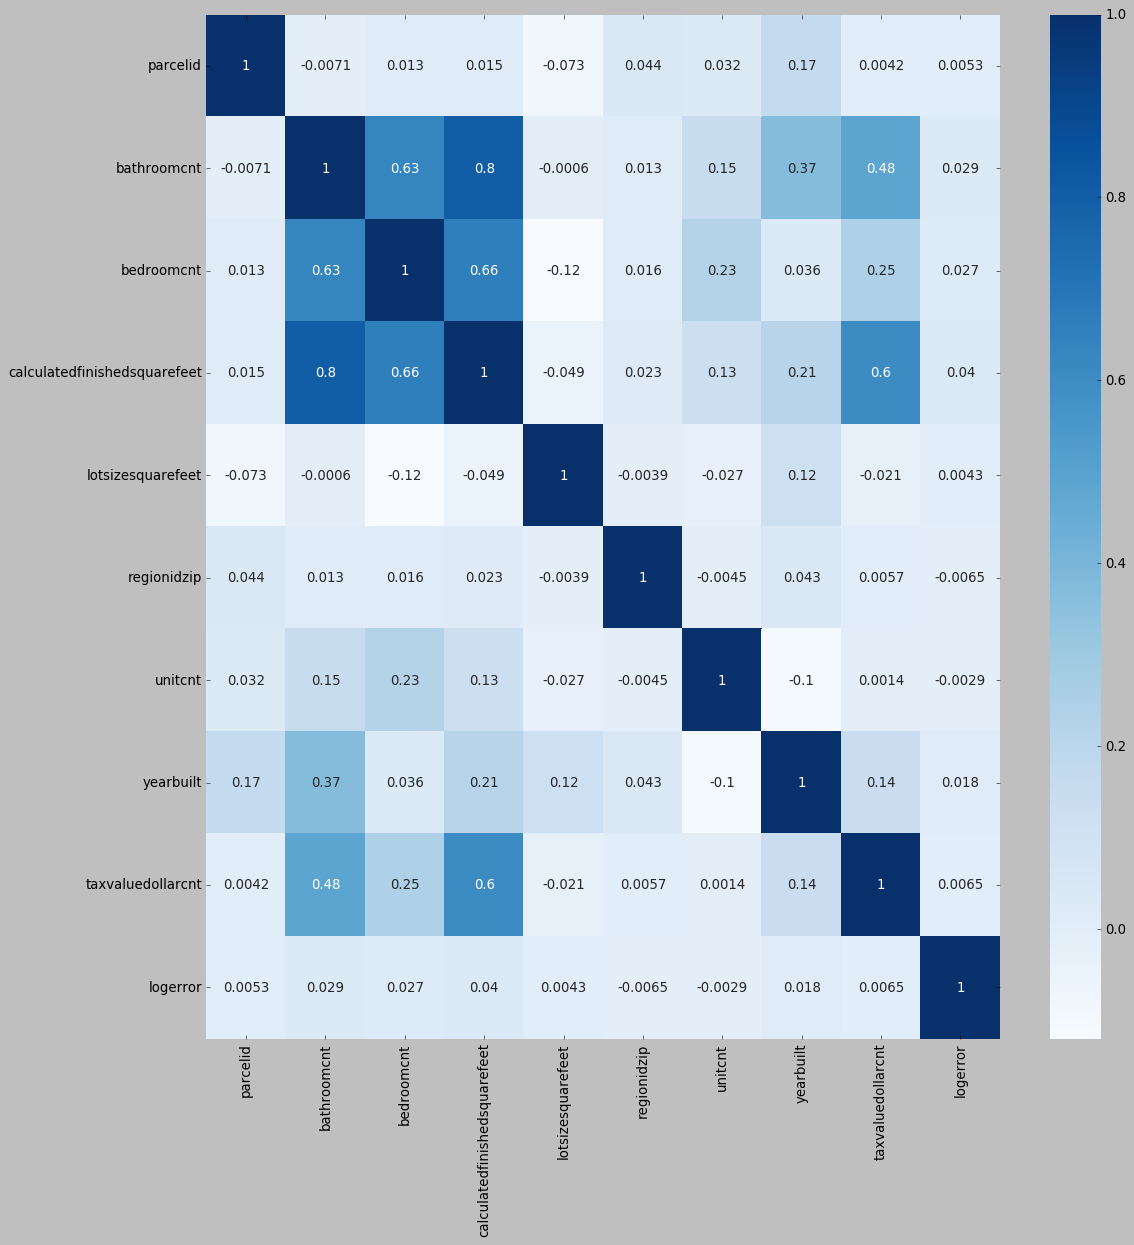

In [32]:
plt.figure(figsize=(16,16))
sns.heatmap(zillow.corr(), cmap='Blues', annot=True)

In [33]:
multi_home = zillow[zillow.unitcnt >= 2]
multi_home.shape

(3476, 10)

In [34]:
multi_home.sort_values('unitcnt')

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,regionidzip,unitcnt,yearbuilt,taxvaluedollarcnt,logerror
58,10966607,2.0,4.0,1700.0,6266.0,96368.0,2.0,1954.0,191095.0,-0.0243
53284,11768735,2.0,5.0,1768.0,6763.0,95992.0,2.0,1914.0,343243.0,-0.1020
53288,11824235,3.0,5.0,2100.0,4540.0,96044.0,2.0,1919.0,190515.0,0.0119
53299,11947239,2.0,4.0,2440.0,5201.0,96020.0,2.0,1931.0,637324.0,-0.1972
53348,12457020,4.0,6.0,2720.0,4505.0,96239.0,2.0,1965.0,321452.0,-0.0769
53367,12634849,2.0,4.0,1488.0,5015.0,96228.0,2.0,1966.0,130784.0,-0.0346
53415,12965457,3.0,6.0,3103.0,11626.0,96273.0,2.0,1922.0,636714.0,-0.0151
53419,13001630,2.0,3.0,1364.0,7309.0,96478.0,2.0,1953.0,146165.0,0.0807
53279,11717909,2.0,4.0,1770.0,5200.0,96043.0,2.0,1917.0,27902.0,0.1765
53611,17276447,4.0,4.0,2393.0,8500.0,96385.0,2.0,1988.0,638988.0,-0.1358


In [89]:
new_non_multi = zillow.drop(zillow[zillow.unitcnt >= 2.0].index)

In [90]:
new_non_multi.shape

(86308, 10)

In [92]:
# Remove unitcnt column from non_multi dataframe.  
new_non_multi = new_non_multi.drop(['unitcnt'], axis=1)

In [93]:
new_non_multi.shape

(86308, 9)

In [94]:
new_non_multi.describe()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,regionidzip,yearbuilt,taxvaluedollarcnt,logerror
count,8.630800e+04,86308.000000,86308.000000,85647.000000,7.619000e+04,86275.000000,85622.000000,8.630700e+04,86308.000000
mean,1.301507e+07,2.258412,2.983420,1744.456268,3.008751e+04,96598.050722,1969.708276,4.591066e+05,0.011558
std,2.545286e+06,0.958143,1.035711,910.008457,1.220623e+05,3598.062361,23.120611,5.585527e+05,0.155806
min,1.071174e+07,0.000000,0.000000,2.000000,1.670000e+02,95982.000000,1885.000000,2.200000e+01,-4.605000
25%,1.154187e+07,2.000000,2.000000,1170.000000,5.752000e+03,96209.000000,1954.000000,1.989390e+05,-0.024300
50%,1.259802e+07,2.000000,3.000000,1516.000000,7.243000e+03,96403.000000,1971.000000,3.432510e+05,0.006000
75%,1.426343e+07,3.000000,4.000000,2055.000000,1.221575e+04,96987.000000,1987.000000,5.409970e+05,0.038300
max,1.629608e+08,20.000000,16.000000,20013.000000,6.971010e+06,399675.000000,2015.000000,2.775000e+07,4.737000


In [95]:
new_non_multi.isnull().sum()

parcelid                            0
bathroomcnt                         0
bedroomcnt                          0
calculatedfinishedsquarefeet      661
lotsizesquarefeet               10118
regionidzip                        33
yearbuilt                         686
taxvaluedollarcnt                   1
logerror                            0
dtype: int64

In [96]:
# Separate single homes without lot size measurements.
single_no_lot_size = new_non_multi[new_non_multi.lotsizesquarefeet.isnull()]
single_no_lot_size.shape

(10118, 9)

In [97]:
# Drop lotsizesquarefeet from non_multi
new_non_multi= new_non_multi.drop(['lotsizesquarefeet'], axis=1)

In [98]:
new_non_multi.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,regionidzip,yearbuilt,taxvaluedollarcnt,logerror
0,17073783,2.5,3.0,1264.0,97081.0,1986.0,191811.0,0.0953
1,17088994,1.0,2.0,777.0,97083.0,1990.0,239679.0,0.0198
2,17100444,2.0,3.0,1101.0,97113.0,1956.0,47853.0,0.0060
3,17102429,1.5,2.0,1554.0,97113.0,1965.0,62914.0,-0.0566
4,17109604,2.5,4.0,2415.0,97084.0,1984.0,554000.0,0.0573


In [99]:
new_non_multi['yearbuilt'] = new_non_multi['yearbuilt'].fillna(1971)
new_non_multi.isnull().sum()

parcelid                          0
bathroomcnt                       0
bedroomcnt                        0
calculatedfinishedsquarefeet    661
regionidzip                      33
yearbuilt                         0
taxvaluedollarcnt                 1
logerror                          0
dtype: int64

In [100]:
new_non_multi.dtypes

parcelid                          int64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
regionidzip                     float64
yearbuilt                       float64
taxvaluedollarcnt               float64
logerror                        float64
dtype: object

In [152]:
non_multi_with_sqft = new_non_multi[new_non_multi.calculatedfinishedsquarefeet > 0.0]
non_multi_with_sqft.shape

(85647, 8)

In [153]:
non_multi_with_sqft_with_zip = non_multi_with_sqft[non_multi_with_sqft.regionidzip > 0.0]
non_multi_with_sqft_with_zip.shape

(85632, 8)

In [154]:
non_multi_with_sqft_with_zip_all_taxvalue = non_multi_with_sqft_with_zip[non_multi_with_sqft_with_zip.taxvaluedollarcnt > 0.0]
non_multi_with_sqft_with_zip_all_taxvalue.isnull().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
regionidzip                     0
yearbuilt                       0
taxvaluedollarcnt               0
logerror                        0
dtype: int64

In [155]:
non_multi_with_sqft_with_zip_all_taxvalue.shape

(85631, 8)

In [156]:
# Remove listings with 0 restrooms as they are not valid to use.
non_multi_with_sqft_with_zip_all_taxvalue = non_multi_with_sqft_with_zip_all_taxvalue[non_multi_with_sqft_with_zip_all_taxvalue.bathroomcnt > 0.0]
non_multi_with_sqft_with_zip_all_taxvalue.shape


(85610, 8)

In [157]:
# Removing top bathroomcnt, 20 bathrooms with 3 bedrooms seems wonky.
non_multi_with_sqft_with_zip_all_taxvalue = non_multi_with_sqft_with_zip_all_taxvalue[non_multi_with_sqft_with_zip_all_taxvalue.bathroomcnt != 20.0]
non_multi_with_sqft_with_zip_all_taxvalue.shape

(85609, 8)

In [158]:
non_multi_with_sqft_with_zip_all_taxvalue.sort_values('bedroomcnt').head(270)

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,regionidzip,yearbuilt,taxvaluedollarcnt,logerror
66779,12086693,1.0,0.0,566.0,96324.0,1974.0,230000.0,-0.0202
17447,12546007,1.0,0.0,342.0,96236.0,1923.0,23898.0,-0.0346
77940,11587326,2.0,0.0,1358.0,96127.0,2004.0,798519.0,0.0315
12337,11656891,1.0,0.0,497.0,96030.0,1965.0,266499.0,0.1655
77957,11787447,1.0,0.0,700.0,95993.0,1899.0,192000.0,-0.0305
36055,10848822,1.0,0.0,475.0,96420.0,1965.0,208000.0,-0.0325
55382,11784563,1.0,0.0,650.0,95995.0,1911.0,356992.0,0.0998
35240,11467453,1.0,0.0,612.0,96129.0,1971.0,90823.0,0.0516
11292,11537233,2.0,0.0,1878.0,96128.0,2007.0,465618.0,0.0198
37094,12015893,1.0,0.0,513.0,96027.0,1974.0,131513.0,-0.0253


In [159]:
# List of homes with 0 bedroomcnt, but more than 1 bathroom.  These will be dropped as they are almost all over 1,000 
# sqft and would most likely have at least 1 bedroom. It is 41 homes.
non_multi_with_sqft_with_zip_all_taxvalue.loc[(non_multi_with_sqft_with_zip_all_taxvalue['bedroomcnt'] == 0.0) &\
                                             (non_multi_with_sqft_with_zip_all_taxvalue['bathroomcnt'] >= 2.0)]

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,regionidzip,yearbuilt,taxvaluedollarcnt,logerror
1777,12013064,2.0,0.0,1110.0,96009.0,2006.0,578000.0,-0.0111
6227,12097064,2.0,0.0,1369.0,96293.0,2002.0,889000.0,0.0392
9023,12556037,2.0,0.0,1980.0,96236.0,2005.0,540000.0,0.0649
9034,11539172,2.0,0.0,1250.0,96128.0,2007.0,699461.0,0.0315
11292,11537233,2.0,0.0,1878.0,96128.0,2007.0,465618.0,0.0198
13060,11539158,2.0,0.0,1290.0,96128.0,2006.0,714000.0,0.0266
13508,11587316,2.0,0.0,1451.0,96127.0,2004.0,1123303.0,0.0733
13958,12013058,2.0,0.0,1110.0,96009.0,2006.0,578000.0,-0.0121
15334,11538718,2.0,0.0,1220.0,96128.0,2008.0,531318.0,-0.0141
17186,11794513,2.0,0.0,1110.0,95994.0,1923.0,460048.0,-0.0212


In [160]:
# Dropping homes with 0 bedrooms and more than 1 restroom.  Shape confirms they dropped.
non_multi_with_sqft_with_zip_all_taxvalue = non_multi_with_sqft_with_zip_all_taxvalue.drop\
    (non_multi_with_sqft_with_zip_all_taxvalue[(non_multi_with_sqft_with_zip_all_taxvalue['bedroomcnt'] == 0.0) &\
    (non_multi_with_sqft_with_zip_all_taxvalue['bathroomcnt'] >= 2.0)].index)
non_multi_with_sqft_with_zip_all_taxvalue.shape

(85568, 8)

In [161]:
# Checking top bedroomcnt's.  They seem legit.
non_multi_with_sqft_with_zip_all_taxvalue.sort_values('bedroomcnt', ascending=False).head(50)

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,regionidzip,yearbuilt,taxvaluedollarcnt,logerror
27224,12093355,5.0,16.0,2584.0,96291.0,1922.0,535489.0,0.0010
2998,14332607,5.0,10.0,3423.0,97016.0,1958.0,437972.0,0.6461
26966,11744312,2.0,9.0,5359.0,96000.0,1903.0,331369.0,0.1790
10138,11808891,3.0,9.0,2811.0,96012.0,1894.0,279374.0,0.0257
17157,17056190,6.0,9.0,3423.0,97099.0,1947.0,681363.0,0.0751
64475,10933420,10.0,9.0,7868.0,96447.0,1935.0,4283915.0,0.0373
77303,12343204,5.0,9.0,3814.0,96208.0,1940.0,554320.0,0.7129
3971,11650903,10.0,9.0,13377.0,96086.0,2003.0,10000000.0,-0.0429
62277,11667356,6.0,9.0,7122.0,96120.0,1938.0,6471555.0,-0.2319
60286,10767193,5.0,8.0,3633.0,96341.0,1977.0,423649.0,-0.0020


In [162]:
# Checking lower end of sqft.  Some of these look to have data integrity issues.  Removing homes under 400 sq ft with 2 or more bedrooms.
non_multi_with_sqft_with_zip_all_taxvalue.sort_values('calculatedfinishedsquarefeet').head(100)

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,regionidzip,yearbuilt,taxvaluedollarcnt,logerror
14950,10902671,3.0,4.0,120.0,96452.0,1939.0,788975.0,0.0602
85018,12236415,2.0,3.0,152.0,96025.0,1939.0,85122.0,0.0050
15130,12561798,1.0,0.0,199.0,96236.0,1928.0,102553.0,0.1017
25781,11620674,1.0,1.0,214.0,96005.0,1962.0,38246.0,2.9530
55978,11618787,1.0,0.0,230.0,96005.0,1961.0,53011.0,0.7775
33415,11572416,1.0,0.0,242.0,96151.0,1957.0,231952.0,0.0266
20123,14280158,1.0,2.0,257.0,96959.0,1954.0,810000.0,0.0998
42100,12561791,1.0,0.0,270.0,96236.0,1928.0,103000.0,0.0733
22057,11781977,1.0,0.0,280.0,95987.0,1923.0,11077.0,0.0926
79586,12546471,1.0,0.0,296.0,96236.0,1928.0,190000.0,0.1840


In [163]:
# List of homes that are under 400 sqft and have more than 1 bedroom.
non_multi_with_sqft_with_zip_all_taxvalue.loc[(non_multi_with_sqft_with_zip_all_taxvalue['calculatedfinishedsquarefeet'] <= 400.0) &\
                                             (non_multi_with_sqft_with_zip_all_taxvalue['bedroomcnt'] >= 2.0)]

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,regionidzip,yearbuilt,taxvaluedollarcnt,logerror
14950,10902671,3.0,4.0,120.0,96452.0,1939.0,788975.0,0.0602
20123,14280158,1.0,2.0,257.0,96959.0,1954.0,810000.0,0.0998
73143,11872685,1.0,2.0,389.0,96013.0,1940.0,86367.0,0.4947
85018,12236415,2.0,3.0,152.0,96025.0,1939.0,85122.0,0.0050


In [164]:
# Dropped the 4 above, shape confirms they dropped.
non_multi_with_sqft_with_zip_all_taxvalue = non_multi_with_sqft_with_zip_all_taxvalue.drop\
    (non_multi_with_sqft_with_zip_all_taxvalue[(non_multi_with_sqft_with_zip_all_taxvalue['bedroomcnt'] >= 2.0) &\
    (non_multi_with_sqft_with_zip_all_taxvalue['calculatedfinishedsquarefeet'] <= 400.0)].index)
non_multi_with_sqft_with_zip_all_taxvalue.shape

(85564, 8)

In [165]:
# Checking lower end of taxvaluedollarcnt.  $22 assessed value seems wrong.  Dropping it.
non_multi_with_sqft_with_zip_all_taxvalue.sort_values('taxvaluedollarcnt').head(50)

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,regionidzip,yearbuilt,taxvaluedollarcnt,logerror
14427,12431927,2.0,2.0,883.0,96216.0,1973.0,22.0,-0.0715
15089,12272795,1.0,1.0,416.0,96092.0,1948.0,7704.0,0.0611
27426,14646864,1.0,1.0,564.0,96963.0,1974.0,7837.0,0.1898
72306,12231898,1.0,1.0,382.0,96040.0,1922.0,8314.0,0.2654
56617,14506872,1.0,1.0,480.0,96989.0,1933.0,8629.0,0.7343
30820,12214075,1.0,1.0,912.0,95983.0,1923.0,10958.0,-0.2917
22057,11781977,1.0,0.0,280.0,95987.0,1923.0,11077.0,0.0926
697,12877292,2.0,3.0,1363.0,96506.0,1901.0,11122.0,0.0237
6451,12230282,1.0,2.0,792.0,96040.0,1926.0,11981.0,0.1017
1532,12273567,1.0,2.0,634.0,96092.0,1948.0,11987.0,-0.0534


In [166]:
# Dropped the one home, shape confirms it's dropped.
non_multi_with_sqft_with_zip_all_taxvalue = non_multi_with_sqft_with_zip_all_taxvalue.drop\
    (non_multi_with_sqft_with_zip_all_taxvalue[(non_multi_with_sqft_with_zip_all_taxvalue['taxvaluedollarcnt'] <= 1000.0)].index)
non_multi_with_sqft_with_zip_all_taxvalue.shape    

(85563, 8)

In [167]:
# Checking higher end of taxvaluedollarcnt.  There are a couple of possible data integrity issues, but not solid enough to remove.
non_multi_with_sqft_with_zip_all_taxvalue.sort_values('taxvaluedollarcnt', ascending=False).head(150)

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,regionidzip,yearbuilt,taxvaluedollarcnt,logerror
67682,11640171,9.0,7.0,10286.0,96086.0,1937.0,27750000.0,-0.4339
88604,11687684,9.0,6.0,9130.0,96116.0,1995.0,26500000.0,0.1035
76324,11648750,8.0,6.0,13352.0,96058.0,2011.0,25605020.0,0.3893
87193,11654953,15.0,7.0,20013.0,96086.0,2000.0,22411718.0,-0.3711
55103,11640165,11.0,7.0,11478.0,96086.0,1999.0,15389241.0,0.2593
89731,14403651,5.5,4.0,5610.0,96969.0,2007.0,14499429.0,0.1258
50403,14324127,7.5,6.0,12777.0,96975.0,2001.0,14149694.0,0.1302
18674,11679245,5.0,2.0,3163.0,96116.0,1953.0,13797600.0,0.0050
58460,14430799,6.0,4.0,9670.0,96961.0,2008.0,13722948.0,0.0218
45690,12022435,5.0,4.0,7170.0,96050.0,2010.0,12756403.0,-0.0284


In [168]:
# Need to drop rows with bad zip codes.
non_multi_with_sqft_with_zip_all_taxvalue.sort_values('regionidzip', ascending=False).head(50)

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,regionidzip,yearbuilt,taxvaluedollarcnt,logerror
7011,12969619,2.0,3.0,2339.0,399675.0,1968.0,993970.0,-0.0202
30452,12969535,2.0,3.0,1352.0,399675.0,1954.0,122025.0,-0.0070
64248,12969498,2.0,3.0,1968.0,399675.0,1959.0,660872.0,-0.1054
27313,12969696,3.0,5.0,2531.0,399675.0,1969.0,614585.0,-0.0856
79296,12969735,3.0,4.0,3189.0,399675.0,1952.0,1174956.0,0.0953
21413,12969545,2.0,3.0,1342.0,399675.0,1954.0,650747.0,-0.0101
68728,12969470,2.0,3.0,2491.0,399675.0,1982.0,182787.0,-0.1532
30453,12969688,3.0,3.0,2787.0,399675.0,1987.0,276666.0,-0.2998
25461,12969562,2.0,3.0,3123.0,399675.0,1955.0,1154597.0,0.0807
51645,12969446,3.0,4.0,2568.0,399675.0,1981.0,640380.0,0.1053


In [169]:
non_multi_with_sqft_with_zip_all_taxvalue.shape

(85563, 8)

In [170]:
non_multi_with_sqft_with_zip_all_taxvalue = non_multi_with_sqft_with_zip_all_taxvalue[non_multi_with_sqft_with_zip_all_taxvalue.regionidzip < 100000.0]
non_multi_with_sqft_with_zip_all_taxvalue.shape


(85551, 8)

In [171]:
non_multi_with_sqft_with_zip_all_taxvalue.dtypes

parcelid                          int64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
regionidzip                     float64
yearbuilt                       float64
taxvaluedollarcnt               float64
logerror                        float64
dtype: object

In [172]:
col_names = list(non_multi_with_sqft_with_zip_all_taxvalue)
col_names

['parcelid',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'regionidzip',
 'yearbuilt',
 'taxvaluedollarcnt',
 'logerror']

# Exploration

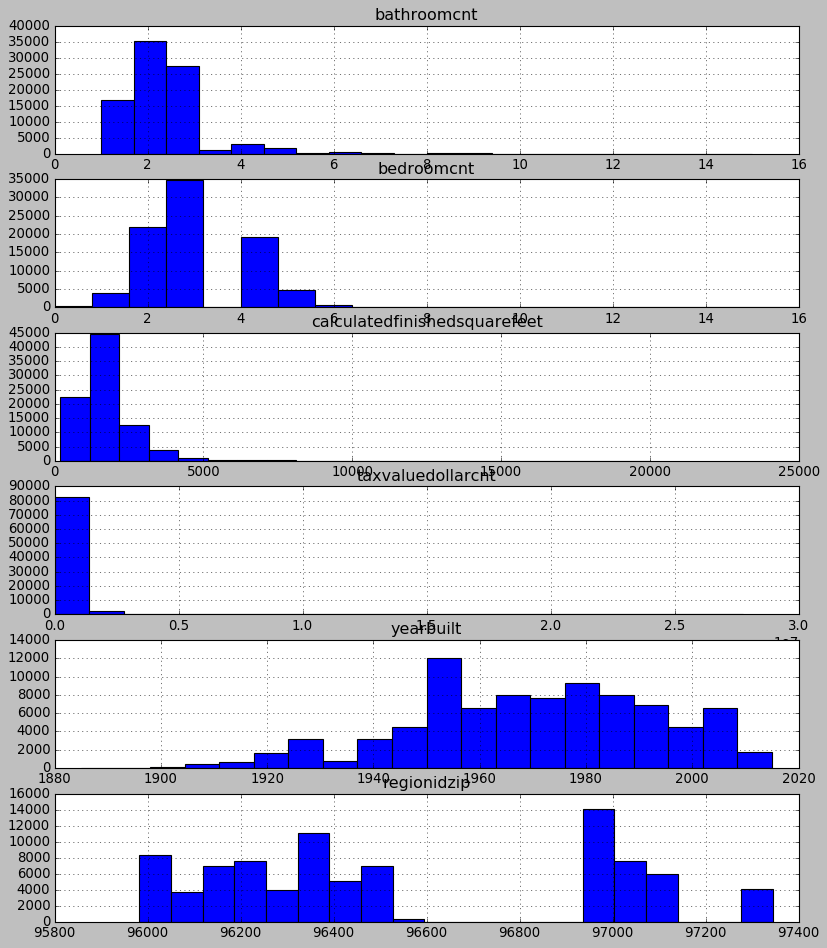

In [173]:
plt.figure(figsize=(12,14))
for i, col in enumerate(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt', 'regionidzip']):
    plot_number = i + 1
    series = non_multi_with_sqft_with_zip_all_taxvalue[col]
    plt.subplot(6, 1, plot_number)
    plt.title(col)
    series.hist(bins=20, density=False, cumulative=False, log=False)

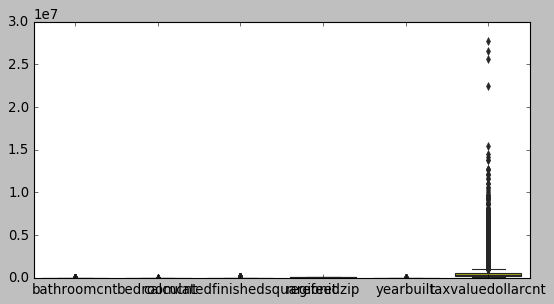

In [174]:
plt.figure(figsize=(8,4))
sns.boxplot(data=non_multi_with_sqft_with_zip_all_taxvalue.drop(columns=['logerror', 'parcelid']))

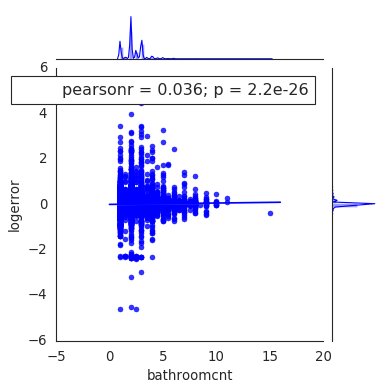

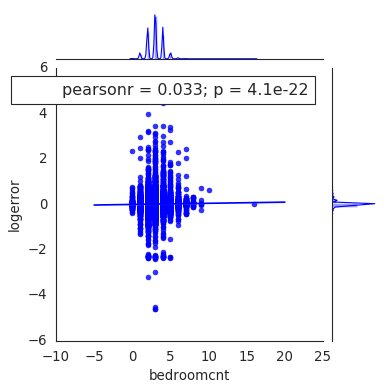

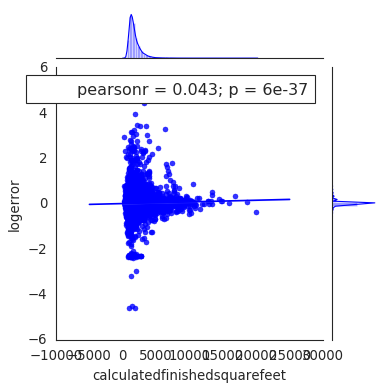

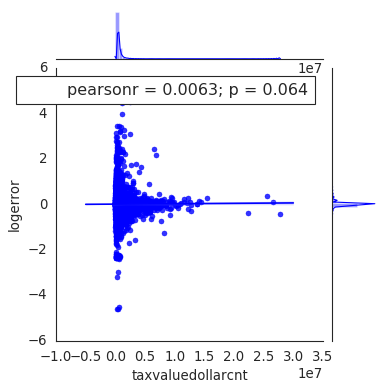

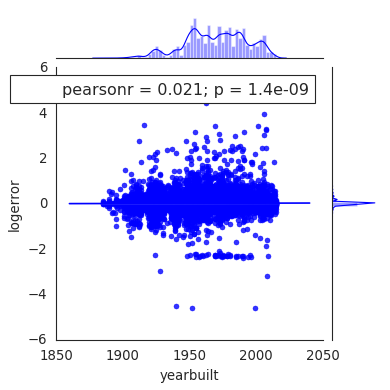

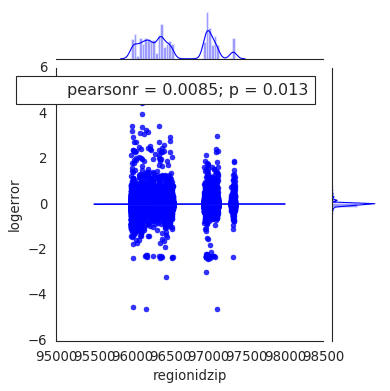

In [175]:
for i, col in enumerate(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt', 'regionidzip']):
    with sns.axes_style('white'):
        plot_number = i + 1
        series = non_multi_with_sqft_with_zip_all_taxvalue[col]
        j = sns.jointplot(non_multi_with_sqft_with_zip_all_taxvalue[col], 'logerror', data=non_multi_with_sqft_with_zip_all_taxvalue, kind='reg', height=5)
        j.annotate(stats.pearsonr)

In [366]:
non_multi_with_sqft_with_zip_all_taxvalue['logerror_abs'] = abs(non_multi_with_sqft_with_zip_all_taxvalue['logerror'])
non_multi_with_sqft_with_zip_all_taxvalue.head()

non_multi_with_sqft_with_zip_all_taxvalue['age'] = 2016 - non_multi_with_sqft_with_zip_all_taxvalue['yearbuilt']
non_multi_with_sqft_with_zip_all_taxvalue.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,regionidzip,yearbuilt,taxvaluedollarcnt,logerror,logerror_abs,age
0,17073783,2.5,3.0,1264.0,97081.0,1986.0,191811.0,0.0953,0.0953,30.0
1,17088994,1.0,2.0,777.0,97083.0,1990.0,239679.0,0.0198,0.0198,26.0
2,17100444,2.0,3.0,1101.0,97113.0,1956.0,47853.0,0.0060,0.0060,60.0
3,17102429,1.5,2.0,1554.0,97113.0,1965.0,62914.0,-0.0566,0.0566,51.0
4,17109604,2.5,4.0,2415.0,97084.0,1984.0,554000.0,0.0573,0.0573,32.0


In [362]:
# Is the logerror significantly different for homes with 3 bedrooms vs those with 5 or more bedrooms? 
# Run a t-test to test this difference.


sample_3bed = non_multi_with_sqft_with_zip_all_taxvalue[non_multi_with_sqft_with_zip_all_taxvalue['bedroomcnt']==3]['logerror_abs']
sample_5bed = non_multi_with_sqft_with_zip_all_taxvalue[non_multi_with_sqft_with_zip_all_taxvalue['bedroomcnt']>=5]['logerror_abs']

print(sample_3bed.mean())
print(sample_5bed.mean())
stats.ttest_ind(sample_3bed, sample_5bed)

0.06205253707368696
0.0754127007568762


Ttest_indResult(statistic=-6.5998909111013795, pvalue=4.165540195829004e-11)

In [ ]:
# What about logerror between homes under 1,000 sq. ft. and homes over 6,000 sq. ft.?

In [365]:
sample_1ksqft = non_multi_with_sqft_with_zip_all_taxvalue[non_multi_with_sqft_with_zip_all_taxvalue['calculatedfinishedsquarefeet'] < 1000]['logerror_abs']
sample_6ksqft = non_multi_with_sqft_with_zip_all_taxvalue[non_multi_with_sqft_with_zip_all_taxvalue['calculatedfinishedsquarefeet'] > 6000]['logerror_abs']

print(sample_1ksqft.mean())
print(sample_6ksqft.mean())
stats.ttest_ind(sample_1ksqft, sample_6ksqft)


0.07533073063380237
0.1534891089108911


Ttest_indResult(statistic=-9.747639535906453, pvalue=2.294292021877431e-22)

In [368]:
# What about logerror between homes under 15 years old and homes over 90 years old?
sample_15year = non_multi_with_sqft_with_zip_all_taxvalue[non_multi_with_sqft_with_zip_all_taxvalue['age']<15]['logerror_abs']
sample_90year = non_multi_with_sqft_with_zip_all_taxvalue[non_multi_with_sqft_with_zip_all_taxvalue['age']>90]['logerror_abs']

print(sample_15year.mean())
print(sample_90year.mean())
stats.ttest_ind(sample_15year, sample_90year)

0.052549837172837364
0.11202511078286514


Ttest_indResult(statistic=-19.611835767307014, pvalue=2.3386175220823914e-84)

# Modeling

In [ ]:
# Use as template for models.
# X = non_multi_with_sqft_with_zip_all_taxvalue[['vars']]
# y = non_multi_with_sqft_with_zip_all_taxvalue[['logerror']]
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)
# train = pd.concat([X_train, y_train], axis=1)
# print("Train columns:  %s" % list(train.columns))
# print("Train dimensions (rows, columns):", train.shape)
# test = pd.concat([X_test, y_test], axis=1)
# print("Test columns:  %s" % list(test.columns))
# print("Test dimensions (rows, columns):", test.shape)
# if X_train.shape[0] == y_train.shape[0]:
#     print("X & y train rows ARE equal")
# else:
#     print("X & y train rows ARE NOT equal")


# if X_test.shape[0] == y_test.shape[0]:
#     print("X & y test rows ARE equal")
# else:
#     print("X & y test rows ARE NOT equal")

# if train.shape[1] == test.shape[1]:
#     print("Number of columns in train & test ARE equal")
# else:
#     print("Number of columns in train & test ARE NOT equal")

# train_split = train.shape[0] / (train.shape[0] + test.shape[0])
# test_split = test.shape[0] / (train.shape[0] + test.shape[0])

# print("Train Split: %.2f" % train_split)
# print("Test Split: %.2f" % test_split)
# print('PearsonR:')
# print([[column, pearsonr(train[column], train.logerror)] for column in X_train] )
# ols_model = sm.OLS(y_train, X_train)
# fit = ols_model.fit()
# print(fit.summary())
# lm1 = LinearRegression()
# lm1.fit(X_train[['taxvaluedollarcnt', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet']], y_train)
# lm1_y_intercept = lm1.intercept_
# print('lm1 y_intercept:')
# print(lm1_y_intercept)
# lm1_coefficients = lm1.coef_
# print('lm1_coefficients: ')
# print(lm1_coefficients)
# pred_lm1 = lm1.predict(X_test)
# sum_of_lm1_pred_residuals = abs(pred_lm1).sum()
# print('Sum of predicted residuals for lm1 on test sample: ')
# print(sum_of_lm1_pred_residuals)
# mse_lm1 = mean_squared_error(y_test, pred_lm1)
# print("Mean squared error: %.2f" % mse_lm1)

In [369]:
X = non_multi_with_sqft_with_zip_all_taxvalue[['taxvaluedollarcnt', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'regionidzip']]
y = non_multi_with_sqft_with_zip_all_taxvalue[['logerror']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)
train = pd.concat([X_train, y_train], axis=1)
print("Train columns:  %s" % list(train.columns))
print("Train dimensions (rows, columns):", train.shape)
test = pd.concat([X_test, y_test], axis=1)
print("Test columns:  %s" % list(test.columns))
print("Test dimensions (rows, columns):", test.shape)
if X_train.shape[0] == y_train.shape[0]:
    print("X & y train rows ARE equal")
else:
    print("X & y train rows ARE NOT equal")


if X_test.shape[0] == y_test.shape[0]:
    print("X & y test rows ARE equal")
else:
    print("X & y test rows ARE NOT equal")

if train.shape[1] == test.shape[1]:
    print("Number of columns in train & test ARE equal")
else:
    print("Number of columns in train & test ARE NOT equal")

train_split = train.shape[0] / (train.shape[0] + test.shape[0])
test_split = test.shape[0] / (train.shape[0] + test.shape[0])

print("Train Split: %.2f" % train_split)
print("Test Split: %.2f" % test_split)
print('-----')

print('PearsonR for train:')
print('  '+ str([[column, pearsonr(train[column], train.logerror)] for column in X_train] ))
print('-----')

ols_model = sm.OLS(y_train, X_train)
fit = ols_model.fit()
print(fit.summary())
print('-----')

lm1 = LinearRegression()
lm1.fit(X_train[['taxvaluedollarcnt', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'regionidzip']], y_train)
lm1_y_intercept = lm1.intercept_
print('lm1 y_intercept for train:')
print(lm1_y_intercept)
lm1_coefficients = lm1.coef_
print('lm1_coefficients for train: ')
print(lm1_coefficients)

pred_lm1_train = lm1.predict(X_train)

sum_of_lm1_pred_residuals_train = abs(pred_lm1_train).sum()
print('Sum of predicted residuals for lm1 on train sample: ')
print(sum_of_lm1_pred_residuals_train)
mse_lm1_train = mean_squared_error(y_train, pred_lm1_train)
print("Mean squared error for train set: %.6f" % mse_lm1_train)

pred_lm1 = lm1.predict(X_test)

sum_of_lm1_pred_residuals = abs(pred_lm1).sum()
print('Sum of predicted residuals for lm1 on test sample: ')
print(sum_of_lm1_pred_residuals)
mse_lm1 = mean_squared_error(y_test, pred_lm1)
print("Mean squared error: %.6f" % mse_lm1)



Train columns:  ['taxvaluedollarcnt', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'regionidzip', 'logerror']
Train dimensions (rows, columns): (68440, 7)
Test columns:  ['taxvaluedollarcnt', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'regionidzip', 'logerror']
Test dimensions (rows, columns): (17111, 7)
X & y train rows ARE equal
X & y test rows ARE equal
Number of columns in train & test ARE equal
Train Split: 0.80
Test Split: 0.20
-----
PearsonR for train:
  [['taxvaluedollarcnt', (0.011222840301561308, 0.0033242015780685285)], ['bedroomcnt', (0.031460876626021976, 1.8353030943174165e-16)], ['bathroomcnt', (0.034549767739839955, 1.5508548143733481e-19)], ['calculatedfinishedsquarefeet', (0.041769268092319026, 8.118011252372505e-28)], ['yearbuilt', (0.019582570959392216, 3.0007190369608223e-07)], ['regionidzip', (0.009841744995633442, 0.010032180236348736)]]
-----
                            OLS Regression Results           

In [372]:
X2 = non_multi_with_sqft_with_zip_all_taxvalue[['yearbuilt']]
y2 = non_multi_with_sqft_with_zip_all_taxvalue[['logerror']]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=.80, random_state=0)
train2 = pd.concat([X2_train, y2_train], axis=1)
print("Train columns:  %s" % list(train2.columns))
print("Train dimensions (rows, columns):", train2.shape)
test2 = pd.concat([X2_test, y2_test], axis=1)
print("Test columns:  %s" % list(test2.columns))
print("Test dimensions (rows, columns):", test2.shape)
if X2_train.shape[0] == y2_train.shape[0]:
    print("X & y train rows ARE equal")
else:
    print("X & y train rows ARE NOT equal")


if X2_test.shape[0] == y2_test.shape[0]:
    print("X & y test rows ARE equal")
else:
    print("X & y test rows ARE NOT equal")

if train2.shape[1] == test2.shape[1]:
    print("Number of columns in train & test ARE equal")
else:
    print("Number of columns in train & test ARE NOT equal")

train2_split = train2.shape[0] / (train2.shape[0] + test2.shape[0])
test2_split = test2.shape[0] / (train2.shape[0] + test2.shape[0])

print("Train Split: %.2f" % train2_split)
print("Test Split: %.2f" % test2_split)
print('PearsonR for train:')
print([[column, pearsonr(train2[column], train2.logerror)] for column in X2_train] )
ols_model = sm.OLS(y2_train, X2_train)
fit = ols_model.fit()
print(fit.summary())
lm2 = LinearRegression()
lm2.fit(X2_train[['yearbuilt']], y2_train)
lm2_y_intercept = lm2.intercept_
print('lm2 y_intercept:')
print(lm2_y_intercept)
lm2_coefficients = lm2.coef_
print('lm2_coefficients: ')
print(lm2_coefficients)

pred_lm2_train = lm2.predict(X2_train)
sum_of_lm2_pred_residuals_train = abs(pred_lm2_train).sum()
print('Sum of predicted residuals for lm1 on train sample: ')
print(sum_of_lm2_pred_residuals_train)
mse_lm2_train = mean_squared_error(y2_train, pred_lm2_train)
print("Mean squared error for train set: %.6f" % mse_lm2_train)

pred_lm2 = lm2.predict(X2_test)
sum_of_lm2_pred_residuals = abs(pred_lm2).sum()
print('Sum of predicted residuals for lm2 on test sample: ')
print(sum_of_lm2_pred_residuals)
mse_lm2 = mean_squared_error(y2_test, pred_lm2)
print("Mean squared error: %.6f" % mse_lm2)

Train columns:  ['yearbuilt', 'logerror']
Train dimensions (rows, columns): (68440, 2)
Test columns:  ['yearbuilt', 'logerror']
Test dimensions (rows, columns): (17111, 2)
X & y train rows ARE equal
X & y test rows ARE equal
Number of columns in train & test ARE equal
Train Split: 0.80
Test Split: 0.20
PearsonR for train:
[['yearbuilt', (0.019582570959392216, 3.0007190369608223e-07)]]
                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     410.5
Date:                Tue, 26 Mar 2019   Prob (F-statistic):           5.19e-91
Time:                        09:01:00   Log-Likelihood:                 31737.
No. Observations:               68440   AIC:                        -6.347e+04
Df Residuals:                   68439   BIC:               

In [375]:
X3 = non_multi_with_sqft_with_zip_all_taxvalue[['taxvaluedollarcnt', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'regionidzip']]
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, train_size=.80, random_state=0)
train3 = pd.concat([X3_train, y_train], axis=1)
print("Train3 columns:  %s" % list(train3.columns))
print("Train3 dimensions (rows, columns):", train3.shape)
test3 = pd.concat([X3_test, y_test], axis=1)
print("Test3 columns:  %s" % list(test3.columns))
print("Test3 dimensions (rows, columns):", test3.shape)

if X3_train.shape[0] == y_train.shape[0]:
    print("X & y train rows ARE equal")
else:
    print("X & y train rows ARE NOT equal")


if X3_test.shape[0] == y_test.shape[0]:
    print("X & y test rows ARE equal")
else:
    print("X & y test rows ARE NOT equal")

if train3.shape[1] == test3.shape[1]:
    print("Number of columns in train & test ARE equal")
else:
    print("Number of columns in train & test ARE NOT equal")

train3_split = train3.shape[0] / (train3.shape[0] + test3.shape[0])
test3_split = test3.shape[0] / (train3.shape[0] + test3.shape[0])

print("Train Split3: %.2f" % train3_split)
print("Test Split3: %.2f" % test3_split)

print('PearsonR: ')
print([[column, pearsonr(train3[column], train3.logerror)] for column in X3_train]) 
ols_model3 = sm.OLS(y_train, X3_train)
fit = ols_model3.fit()
print(fit.summary())
lm3 = LinearRegression()
lm3.fit(X3_train[['taxvaluedollarcnt', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'regionidzip']], y_train)
lm3_y_intercept = lm3.intercept_
print('lm3 y_intercept:')
print(lm3_y_intercept)
lm3_coefficients = lm3.coef_
print('lm3_coefficients')
print(lm3_coefficients)

pred_lm3 = lm3.predict(X3_test)
sum_of_lm3_pred_residuals = abs(pred_lm3).sum()
print('Sum of lm3_pred residuals: ')
print(sum_of_lm3_pred_residuals)
mse_lm3 = mean_squared_error(y_test, pred_lm3)
print("lm3 mean squared error: %.6f" % mse_lm3)


Train3 columns:  ['taxvaluedollarcnt', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'regionidzip', 'logerror']
Train3 dimensions (rows, columns): (68440, 6)
Test3 columns:  ['taxvaluedollarcnt', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'regionidzip', 'logerror']
Test3 dimensions (rows, columns): (17111, 6)
X & y train rows ARE equal
X & y test rows ARE equal
Number of columns in train & test ARE equal
Train Split3: 0.80
Test Split3: 0.20
PearsonR: 
[['taxvaluedollarcnt', (0.011222840301561308, 0.0033242015780685285)], ['bedroomcnt', (0.031460876626021976, 1.8353030943174165e-16)], ['bathroomcnt', (0.034549767739839955, 1.5508548143733481e-19)], ['calculatedfinishedsquarefeet', (0.041769268092319026, 8.118011252372505e-28)], ['regionidzip', (0.009841744995633442, 0.010032180236348736)]]
                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.008
Model:   

In [354]:
X_abs = non_multi_with_sqft_with_zip_all_taxvalue[['taxvaluedollarcnt', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet']]
y_abs = abs(non_multi_with_sqft_with_zip_all_taxvalue[['logerror']])
X_abs_train, X_abs_test, y_abs_train, y_abs_test = train_test_split(X_abs, y_abs, train_size=.80, random_state=0)
train_abs = pd.concat([X_abs_train, y_abs_train], axis=1)
print("Train_abs columns:  %s" % list(train_abs.columns))
print("Train_abs dimensions (rows, columns):", train_abs.shape)
test_abs = pd.concat([X_abs_test, y_abs_test], axis=1)
print("Test_abs columns:  %s" % list(test_abs.columns))
print("Test_abs dimensions (rows, columns):", test_abs.shape)
if X_abs_train.shape[0] == y_abs_train.shape[0]:
    print("X & y train rows ARE equal")
else:
    print("X & y train rows ARE NOT equal")


if X_abs_test.shape[0] == y_abs_test.shape[0]:
    print("X & y test rows ARE equal")
else:
    print("X & y test rows ARE NOT equal")

if train_abs.shape[1] == test_abs.shape[1]:
    print("Number of columns in train & test ARE equal")
else:
    print("Number of columns in train & test ARE NOT equal")

train_abs_split = train_abs.shape[0] / (train_abs.shape[0] + test_abs.shape[0])
test_abs_split = test_abs.shape[0] / (train_abs.shape[0] + test_abs.shape[0])

print("Train Split: %.2f" % train_split)
print("Test Split: %.2f" % test_split)
print('PearsonR: ')
[[column, pearsonr(train_abs[column], train_abs.logerror)] for column in X_abs_train] 
ols_model_abs = sm.OLS(y_abs_train, X_abs_train)
fit = ols_model_abs.fit()
print(fit.summary())
lm1_abs1 = LinearRegression()
lm1_abs1.fit(X_abs_train[['taxvaluedollarcnt', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet']], y_abs_train)
lm1_abs1_y_intercept = lm1_abs1.intercept_
print('lm_abs y_intercept: ')
print(lm1_abs1_y_intercept)
lm1_abs1_coefficients = lm1_abs1.coef_
print('lm_abs_coefficients: ')
print(lm1_abs1_coefficients)
pred_lm1_abs1 = lm1_abs1.predict(X_abs_test)
sum_of_abs_pred_residuals = abs(pred_lm1_abs1).sum()
print('Sum of residuals for lm_abs: ')
print(sum_of_abs_pred_residuals)
mse_abs = mean_squared_error(y_abs_test, pred_lm1_abs1)
print("lm_abs mean squared error: %.6f" % mse_abs)


Train_abs columns:  ['taxvaluedollarcnt', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'logerror']
Train_abs dimensions (rows, columns): (68440, 5)
Test_abs columns:  ['taxvaluedollarcnt', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'logerror']
Test_abs dimensions (rows, columns): (17111, 5)
X & y train rows ARE equal
X & y test rows ARE equal
Number of columns in train & test ARE equal
Train Split: 0.80
Test Split: 0.20
PearsonR: 
                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     3276.
Date:                Mon, 25 Mar 2019   Prob (F-statistic):               0.00
Time:                        16:22:10   Log-Likelihood:                 37528.
No. Observations:               68440   AIC:             

Text(0, 0.5, 'Residuals')

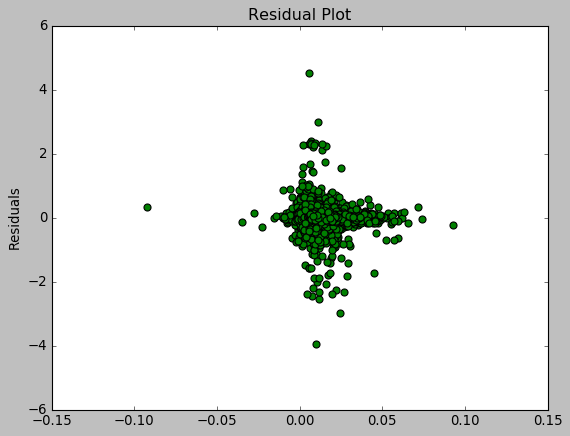

In [376]:
plt.scatter(pred_lm1, pred_lm1-y_test, c='g', s=40)
plt.title('Residual Plot')
plt.ylabel('Residuals')


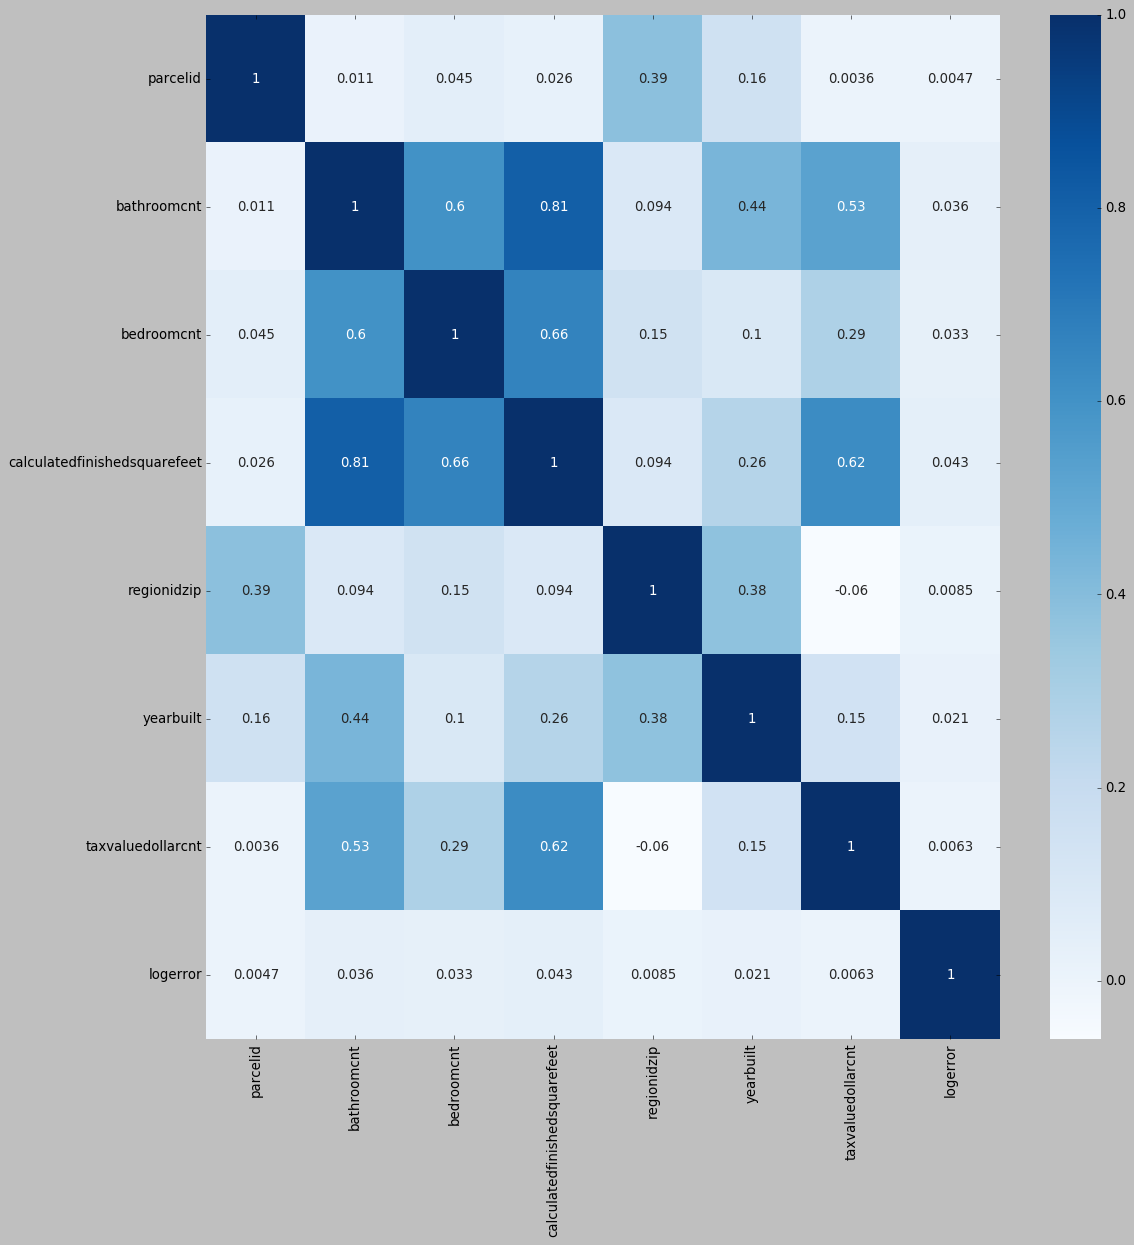

In [179]:
plt.figure(figsize=(16, 16))
sns.heatmap(non_multi_with_sqft_with_zip_all_taxvalue.corr(), cmap='Blues', annot=True)

In [188]:
list(zillow_all)

['parcelid',
 'airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fips',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt',
 'numberofstories',
 'firep

In [256]:
usable_df = zillow_all.drop(['architecturalstyletypeid',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fips',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt',
 'fireplaceflag',
 'taxvaluedollarcnt',
 'assessmentyear',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'censustractandblock'], axis=1)
print('shape:')
print(usable_df.shape)
print(usable_df.head())
print(usable_df.isnull().sum())


shape:
(90275, 20)
   parcelid  airconditioningtypeid  buildingclasstypeid  \
0  17073783                    NaN                  NaN   
1  17088994                    NaN                  NaN   
2  17100444                    NaN                  NaN   
3  17102429                    NaN                  NaN   
4  17109604                    NaN                  NaN   

   buildingqualitytypeid  calculatedbathnbr  decktypeid  fireplacecnt  \
0                    NaN                2.5         NaN           NaN   
1                    NaN                1.0         NaN           NaN   
2                    NaN                2.0         NaN           NaN   
3                    NaN                1.5         NaN           1.0   
4                    NaN                2.5         NaN           1.0   

   fullbathcnt propertycountylandusecode  propertylandusetypeid  roomcnt  \
0          2.0                      1128                  265.0      5.0   
1          1.0                     

In [257]:
# Remove features with too many null values.
usable_df = usable_df.drop(['airconditioningtypeid',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'decktypeid',
 'fireplacecnt',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'numberofstories'], axis=1)

In [258]:
usable_df.isnull().sum()

parcelid                         0
calculatedbathnbr             1182
fullbathcnt                   1182
propertycountylandusecode        1
propertylandusetypeid            0
roomcnt                          0
structuretaxvaluedollarcnt     380
landtaxvaluedollarcnt            1
taxamount                        6
logerror                         0
transactiondate                  0
dtype: int64

In [259]:
usable_df.dtypes

parcelid                        int64
calculatedbathnbr             float64
fullbathcnt                   float64
propertycountylandusecode      object
propertylandusetypeid         float64
roomcnt                       float64
structuretaxvaluedollarcnt    float64
landtaxvaluedollarcnt         float64
taxamount                     float64
logerror                      float64
transactiondate                object
dtype: object

In [260]:
# Tried to convert the table to numeric, but propertycountylandusecode seems to have a lot of strings with numbers, but a letter or two entered.  Dropping that feature.
usable_df = usable_df.drop('propertycountylandusecode', axis=1)


In [261]:
usable_df.head()

,parcelid,calculatedbathnbr,fullbathcnt,propertylandusetypeid,roomcnt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate
0,17073783,2.5,2.0,265.0,5.0,115087.0,76724.0,2015.06,0.0953,2016-01-27
1,17088994,1.0,1.0,266.0,4.0,143809.0,95870.0,2581.30,0.0198,2016-03-30
2,17100444,2.0,2.0,261.0,5.0,33619.0,14234.0,591.64,0.0060,2016-05-27
3,17102429,1.5,1.0,261.0,5.0,45609.0,17305.0,682.78,-0.0566,2016-06-07
4,17109604,2.5,2.0,261.0,8.0,277000.0,277000.0,5886.92,0.0573,2016-08-08


In [262]:
usable_df.transactiondate = usable_df.transactiondate.str.replace('-', '')

In [263]:
usable_df.head()

,parcelid,calculatedbathnbr,fullbathcnt,propertylandusetypeid,roomcnt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate
0,17073783,2.5,2.0,265.0,5.0,115087.0,76724.0,2015.06,0.0953,20160127
1,17088994,1.0,1.0,266.0,4.0,143809.0,95870.0,2581.30,0.0198,20160330
2,17100444,2.0,2.0,261.0,5.0,33619.0,14234.0,591.64,0.0060,20160527
3,17102429,1.5,1.0,261.0,5.0,45609.0,17305.0,682.78,-0.0566,20160607
4,17109604,2.5,2.0,261.0,8.0,277000.0,277000.0,5886.92,0.0573,20160808


In [264]:
usable_df['transactiondate'] = pd.to_numeric(usable_df['transactiondate'])

In [265]:
usable_df.dtypes

parcelid                        int64
calculatedbathnbr             float64
fullbathcnt                   float64
propertylandusetypeid         float64
roomcnt                       float64
structuretaxvaluedollarcnt    float64
landtaxvaluedollarcnt         float64
taxamount                     float64
logerror                      float64
transactiondate                 int64
dtype: object

In [266]:
usable_df.describe()

,parcelid,calculatedbathnbr,fullbathcnt,propertylandusetypeid,roomcnt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate
count,9.027500e+04,89093.000000,89093.000000,90275.000000,90275.000000,8.989500e+04,9.027400e+04,90269.000000,90275.000000,9.027500e+04
mean,1.298466e+07,2.309216,2.241231,261.832179,1.478516,1.800934e+05,2.783353e+05,5983.975927,0.011457,2.016060e+07
std,2.504510e+06,0.976172,0.963142,5.182901,2.819627,2.091299e+05,4.004955e+05,6838.876956,0.161079,2.809622e+02
min,1.071174e+07,1.000000,1.000000,31.000000,0.000000,1.000000e+02,2.200000e+01,49.080000,-4.605000,2.016010e+07
25%,1.155950e+07,2.000000,2.000000,261.000000,0.000000,8.124500e+04,8.222800e+04,2872.830000,-0.025300,2.016040e+07
50%,1.254734e+07,2.000000,2.000000,261.000000,0.000000,1.320000e+05,1.929700e+05,4542.750000,0.006000,2.016061e+07
75%,1.422755e+07,3.000000,3.000000,266.000000,0.000000,2.105345e+05,3.454195e+05,6901.090000,0.039200,2.016082e+07
max,1.629608e+08,20.000000,20.000000,275.000000,18.000000,9.948100e+06,2.450000e+07,321936.090000,4.737000,2.016123e+07


In [267]:
# The median for roomcnt is 0.  That column seems to not be good data.  Dropping it.
# usable_df = usable_df.drop('propertycountylandusecode', axis=1)
usable_df = usable_df.drop('roomcnt', axis=1)

In [268]:
usable_df.sort_values('propertylandusetypeid')

,parcelid,calculatedbathnbr,fullbathcnt,propertylandusetypeid,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate
6714,17077109,NaN,NaN,31.0,302704.0,284614.0,6277.96,-0.1416,20160721
65820,11289311,NaN,NaN,31.0,32606.0,49637.0,1808.85,0.1848,20160713
9971,11749637,NaN,NaN,31.0,41590.0,30572.0,5869.97,0.2957,20161024
23001,10878882,NaN,NaN,31.0,169577.0,190621.0,4520.77,0.1115,20160325
15530,12235042,NaN,NaN,31.0,6499.0,6499.0,3403.34,0.4787,20160927
64517,11396619,NaN,NaN,31.0,62839.0,316943.0,4880.38,0.2769,20160311
77502,11633947,NaN,NaN,31.0,147062.0,639421.0,10100.28,-2.6880,20160708
25617,12445935,NaN,NaN,31.0,33063.0,38325.0,1453.06,0.1151,20160225
26253,11767240,NaN,NaN,31.0,60956.0,44646.0,1558.05,-0.0545,20160826
12608,12201486,NaN,NaN,31.0,138219.0,46295.0,3935.80,0.1638,20160204


In [269]:
# Dropping homes with 31 and 47 in propertylanduseid.  This column looks like it should have a number in the 200's.
usable_df = usable_df[usable_df.propertylandusetypeid > 200]

In [270]:
usable_df.isnull().sum()

parcelid                         0
calculatedbathnbr             1165
fullbathcnt                   1165
propertylandusetypeid            0
structuretaxvaluedollarcnt     380
landtaxvaluedollarcnt            1
taxamount                        6
logerror                         0
transactiondate                  0
dtype: int64

In [271]:
# Drop all null values.
usable_df = usable_df.dropna()

In [272]:
usable_df.isnull().sum()

parcelid                      0
calculatedbathnbr             0
fullbathcnt                   0
propertylandusetypeid         0
structuretaxvaluedollarcnt    0
landtaxvaluedollarcnt         0
taxamount                     0
logerror                      0
transactiondate               0
dtype: int64

In [273]:
usable_df.describe()

,parcelid,calculatedbathnbr,fullbathcnt,propertylandusetypeid,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate
count,8.902300e+04,89023.000000,89023.000000,89023.000000,8.902300e+04,8.902300e+04,89023.000000,89023.000000,8.902300e+04
mean,1.297210e+07,2.309061,2.241039,261.923671,1.797904e+05,2.773691e+05,5963.791212,0.011538,2.016060e+07
std,2.507632e+06,0.975898,0.962869,3.912184,2.078385e+05,3.984315e+05,6786.239644,0.158001,2.807608e+02
min,1.071174e+07,1.000000,1.000000,246.000000,1.000000e+02,2.780000e+02,49.080000,-4.605000,2.016010e+07
25%,1.155585e+07,2.000000,2.000000,261.000000,8.142900e+04,8.235050e+04,2879.665000,-0.025300,2.016041e+07
50%,1.254231e+07,2.000000,2.000000,261.000000,1.321230e+05,1.932840e+05,4543.120000,0.006000,2.016061e+07
75%,1.421974e+07,3.000000,3.000000,266.000000,2.104220e+05,3.450000e+05,6888.325000,0.038300,2.016082e+07
max,1.629608e+08,20.000000,20.000000,275.000000,9.948100e+06,2.450000e+07,321936.090000,4.737000,2.016123e+07


In [274]:
usable_df.sort_values('structuretaxvaluedollarcnt')

,parcelid,calculatedbathnbr,fullbathcnt,propertylandusetypeid,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate
63094,10803424,2.0,2.0,266.0,100.0,90609.0,1240.91,-0.1087,20160426
11804,10765477,2.0,2.0,261.0,100.0,307217.0,3879.88,-0.0151,20160922
44273,11330994,1.0,1.0,261.0,100.0,50900.0,1416.88,0.7761,20160106
54819,13031680,2.0,2.0,261.0,101.0,591500.0,9882.48,-0.1020,20160916
82296,11922840,3.0,3.0,247.0,107.0,961655.0,11666.60,0.1881,20160923
13255,12001271,4.0,4.0,248.0,118.0,553133.0,7789.78,0.0723,20160518
13696,12086144,2.0,2.0,261.0,144.0,335539.0,3693.95,0.0583,20160920
79865,10842476,4.0,4.0,248.0,144.0,267619.0,3469.23,0.0411,20160311
27087,10949094,4.0,4.0,248.0,146.0,289691.0,3327.18,-0.0998,20161228
89084,11941362,1.0,1.0,261.0,148.0,194764.0,6537.07,-0.0315,20160830


In [275]:
# Drop homes with structure value less than $1,000.
usable_df = usable_df.drop(usable_df[usable_df.structuretaxvaluedollarcnt <= 1000].index)

In [276]:
usable_df.sort_values('structuretaxvaluedollarcnt', ascending=False).head(50)

,parcelid,calculatedbathnbr,fullbathcnt,propertylandusetypeid,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate
67682,11640171,9.0,9.0,261.0,9948100.0,17801900.0,321936.09,-0.4339,20160607
76324,11648750,8.0,8.0,261.0,7838271.0,17766749.0,311064.07,0.3893,20160426
60710,11650918,9.0,9.0,261.0,7682031.0,1675524.0,114302.94,0.3279,20160111
3971,11650903,10.0,10.0,261.0,6500000.0,3500000.0,121804.86,-0.0429,20160711
55103,11640165,11.0,11.0,261.0,6192129.0,9197112.0,181533.24,0.2593,20160408
37525,11638659,10.0,10.0,261.0,6076315.0,3122889.0,109050.78,0.0516,20160719
39564,14322040,9.0,8.0,261.0,5680479.0,3028712.0,98290.08,0.1204,20160121
87193,11654953,15.0,15.0,261.0,5355639.0,17056079.0,272407.03,-0.3711,20161020
41820,10755837,6.0,6.0,261.0,5176916.0,1577339.0,85293.85,0.0526,20160108
15921,11655826,7.0,7.0,261.0,4969342.0,2828404.0,94997.03,-0.2421,20160106


In [277]:
usable_df.sort_values('landtaxvaluedollarcnt').head(50)

,parcelid,calculatedbathnbr,fullbathcnt,propertylandusetypeid,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate
24806,11133251,3.0,3.0,266.0,273780.0,278.0,4535.12,0.3257,20160722
26199,11280783,2.0,2.0,261.0,95650.0,370.0,1946.41,-0.0020,20160527
82838,12659459,2.0,2.0,266.0,344097.0,1319.0,5293.86,-0.0450,20160822
20659,14752355,1.0,1.0,266.0,66422.0,1327.0,1163.74,-0.0492,20160216
76899,12659507,1.0,1.0,266.0,379375.0,1432.0,5700.51,-0.0834,20160129
55191,12659388,1.0,1.0,266.0,435630.0,1546.0,6361.44,0.0630,20160108
26273,12015279,3.0,3.0,266.0,261183.0,1576.0,5629.58,0.0602,20160902
55415,17204601,1.0,1.0,261.0,19333.0,1998.0,289.32,-0.0367,20160401
33445,11779183,1.0,1.0,266.0,101900.0,2178.0,1249.00,0.0257,20160721
65627,14612212,1.0,1.0,266.0,61374.0,2200.0,1043.82,-0.0651,20160406


In [278]:
# Drop homes with landtaxvalue under $1,000.
usable_df = usable_df.drop(usable_df[usable_df.landtaxvaluedollarcnt <= 1000].index)

In [279]:
usable_df.sort_values('landtaxvaluedollarcnt', ascending=False).head(50)

,parcelid,calculatedbathnbr,fullbathcnt,propertylandusetypeid,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate
88604,11687684,9.0,9.0,261.0,2000000.0,24500000.0,305669.84,0.1035,20160913
67682,11640171,9.0,9.0,261.0,9948100.0,17801900.0,321936.09,-0.4339,20160607
76324,11648750,8.0,8.0,261.0,7838271.0,17766749.0,311064.07,0.3893,20160426
87193,11654953,15.0,15.0,261.0,5355639.0,17056079.0,272407.03,-0.3711,20161020
18674,11679245,5.0,5.0,261.0,647600.0,13150000.0,162551.69,0.0050,20160309
89731,14403651,5.5,5.0,261.0,1404106.0,13095323.0,150608.72,0.1258,20160831
37529,11683635,3.0,3.0,247.0,750000.0,12000000.0,147539.80,0.0218,20160511
50403,14324127,7.5,6.0,261.0,2600694.0,11549000.0,159327.82,0.1302,20160720
77251,11686116,4.0,4.0,261.0,869855.0,11308158.0,140719.67,-0.2095,20160915
45690,12022435,5.0,5.0,260.0,2510296.0,10246107.0,155003.23,-0.0284,20160127


In [280]:
usable_df.sort_values('taxamount').head(50)

,parcelid,calculatedbathnbr,fullbathcnt,propertylandusetypeid,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate
41863,17168246,3.0,3.0,261.0,44652.0,14234.0,49.08,0.0334,20160711
70305,17138597,2.0,2.0,261.0,130915.0,22066.0,85.96,0.0149,20160414
27426,14646864,1.0,1.0,266.0,3918.0,3919.0,96.74,0.1898,20160422
43273,17273277,2.0,2.0,261.0,94156.0,23992.0,102.02,-0.0845,20160412
56617,14506872,1.0,1.0,261.0,3286.0,5343.0,108.98,0.7343,20160201
21646,10939219,2.0,2.0,261.0,47101.0,39348.0,126.28,0.0723,20160628
77853,14308912,2.5,2.0,261.0,57872.0,52458.0,126.72,0.0564,20160519
43300,10878561,1.0,1.0,261.0,26495.0,30366.0,133.32,-0.0020,20160419
77132,10789339,2.0,2.0,261.0,28938.0,40163.0,150.87,-0.0080,20161025
22057,11781977,1.0,1.0,266.0,6094.0,4983.0,181.22,0.0926,20160429


In [281]:
# Dropping the bottom two, the taxamount doesn't seem to be accurate compared to the other values.
usable_df = usable_df.drop(usable_df[usable_df.taxamount <= 90].index)

In [282]:
usable_df.sort_values('taxamount', ascending=False).head(50)

,parcelid,calculatedbathnbr,fullbathcnt,propertylandusetypeid,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate
67682,11640171,9.0,9.0,261.0,9948100.0,17801900.0,321936.09,-0.4339,20160607
76324,11648750,8.0,8.0,261.0,7838271.0,17766749.0,311064.07,0.3893,20160426
88604,11687684,9.0,9.0,261.0,2000000.0,24500000.0,305669.84,0.1035,20160913
87193,11654953,15.0,15.0,261.0,5355639.0,17056079.0,272407.03,-0.3711,20161020
3250,11648751,5.0,5.0,261.0,1733966.0,5201898.0,248725.74,-0.2383,20161216
55103,11640165,11.0,11.0,261.0,6192129.0,9197112.0,181533.24,0.2593,20160408
37530,11684252,3.0,3.0,261.0,210102.0,340650.0,173218.07,-0.2256,20160913
58460,14430799,6.0,5.0,261.0,3886701.0,9836247.0,169538.68,0.0218,20160322
18674,11679245,5.0,5.0,261.0,647600.0,13150000.0,162551.69,0.0050,20160309
19780,14430802,7.0,6.0,261.0,4208411.0,8528026.0,159382.92,-0.2718,20160111


In [283]:
usable_df.describe()

,parcelid,calculatedbathnbr,fullbathcnt,propertylandusetypeid,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate
count,8.900400e+04,89004.000000,89004.000000,89004.000000,8.900400e+04,8.900400e+04,89004.000000,89004.000000,8.900400e+04
mean,1.297228e+07,2.309082,2.241045,261.924352,1.798226e+05,2.773466e+05,5963.903950,0.011519,2.016060e+07
std,2.507732e+06,0.975879,0.962848,3.911383,2.078466e+05,3.983617e+05,6786.093143,0.157953,2.807551e+02
min,1.071174e+07,1.000000,1.000000,246.000000,1.019000e+03,1.319000e+03,96.740000,-4.605000,2.016010e+07
25%,1.155594e+07,2.000000,2.000000,261.000000,8.145900e+04,8.235100e+04,2879.787500,-0.025300,2.016041e+07
50%,1.254254e+07,2.000000,2.000000,261.000000,1.321450e+05,1.932685e+05,4543.280000,0.006000,2.016061e+07
75%,1.421990e+07,3.000000,3.000000,266.000000,2.104518e+05,3.450000e+05,6888.372500,0.038300,2.016082e+07
max,1.629608e+08,20.000000,20.000000,275.000000,9.948100e+06,2.450000e+07,321936.090000,4.737000,2.016123e+07


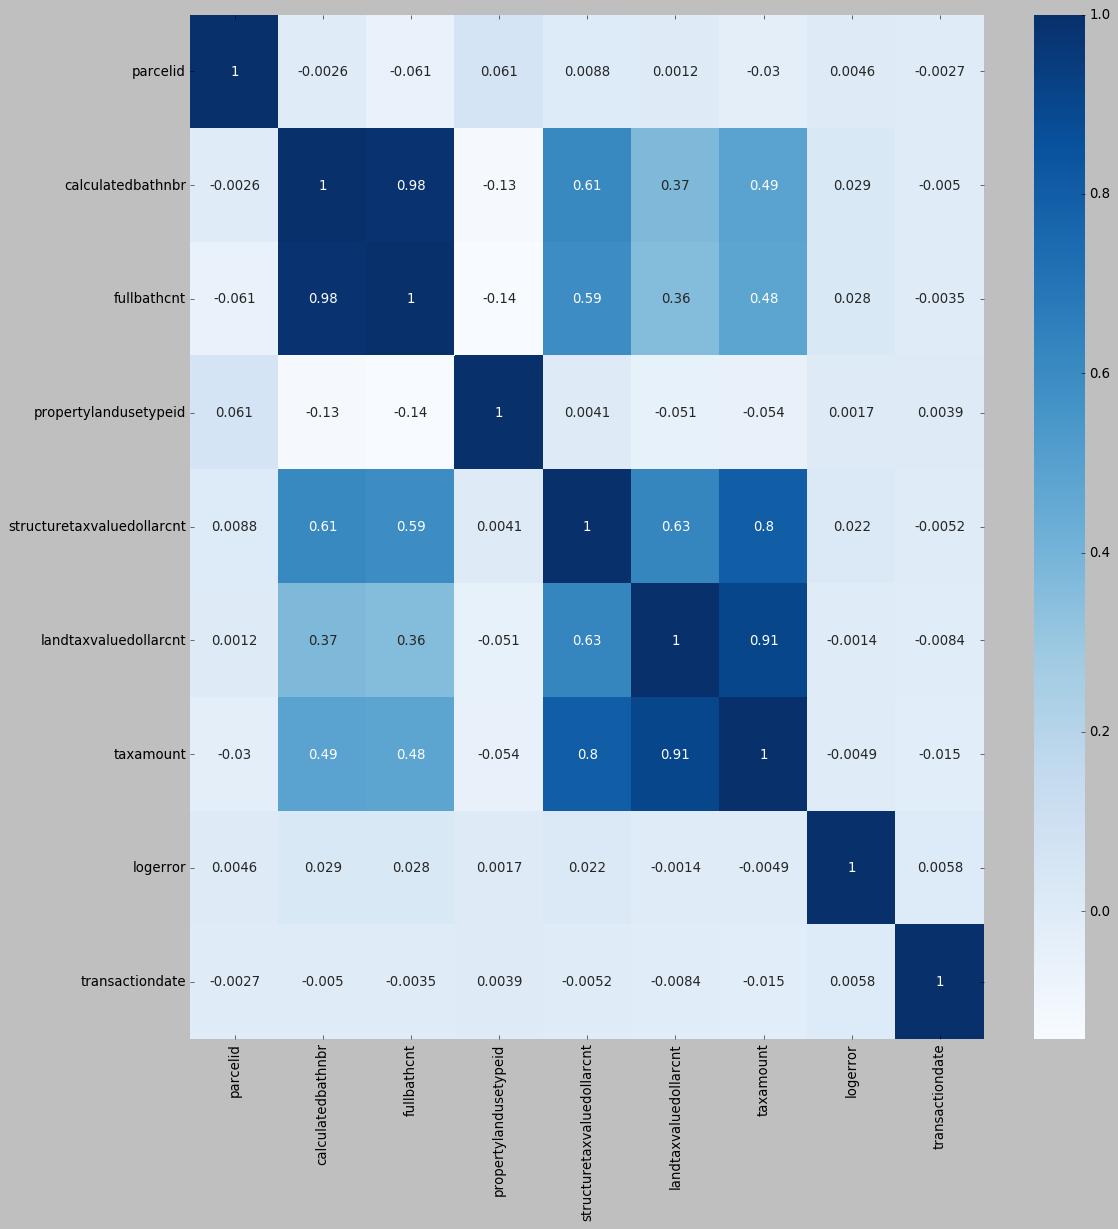

In [284]:
plt.figure(figsize=(16, 16))
sns.heatmap(usable_df.corr(), cmap='Blues', annot=True)

In [286]:
cols_usable_df = list(usable_df)
cols_usable_df

['parcelid',
 'calculatedbathnbr',
 'fullbathcnt',
 'propertylandusetypeid',
 'structuretaxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'logerror',
 'transactiondate']

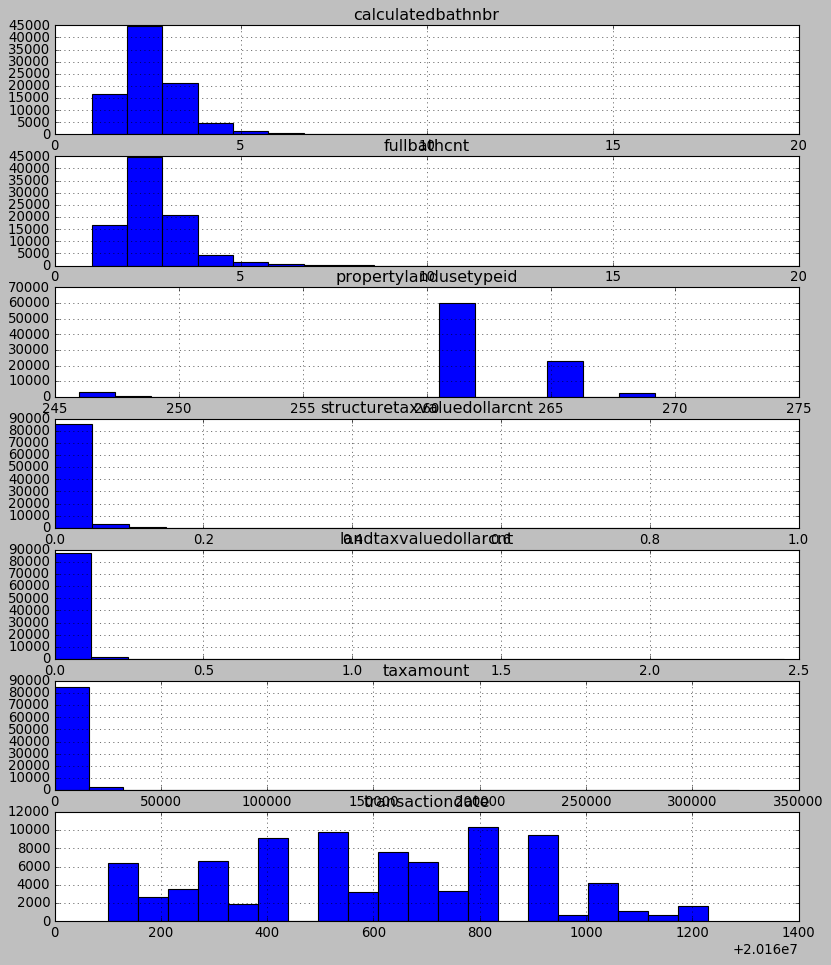

In [287]:
plt.figure(figsize=(12,14))
for i, col in enumerate(['calculatedbathnbr',
 'fullbathcnt',
 'propertylandusetypeid',
 'structuretaxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'transactiondate']):
    plot_number = i + 1
    series = usable_df[col]
    plt.subplot(7, 1, plot_number)
    plt.title(col)
    series.hist(bins=20, density=False, cumulative=False, log=False)

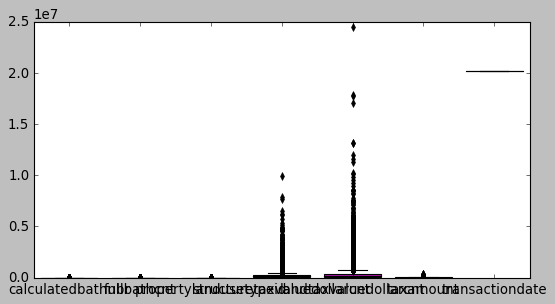

In [289]:
plt.figure(figsize=(8,4))
sns.boxplot(data=usable_df.drop(columns=['logerror', 'parcelid']))

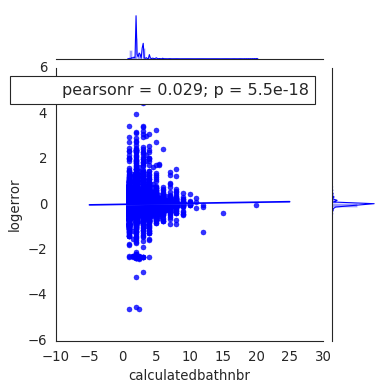

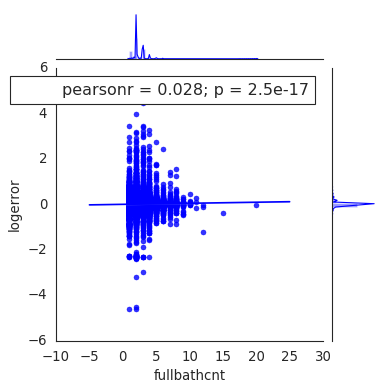

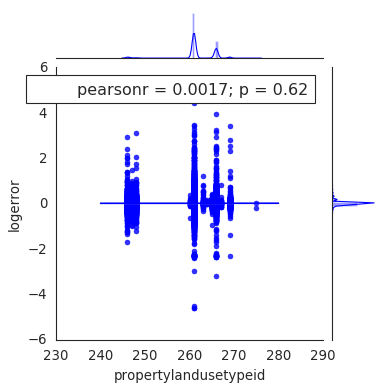

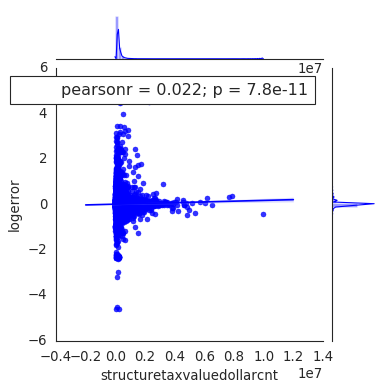

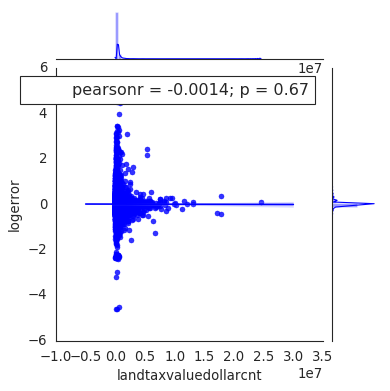

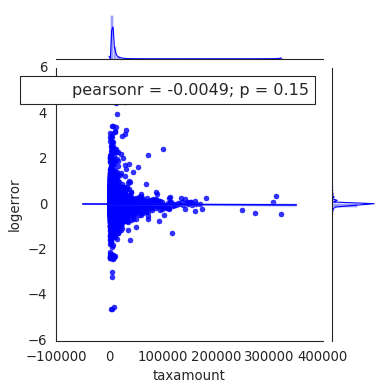

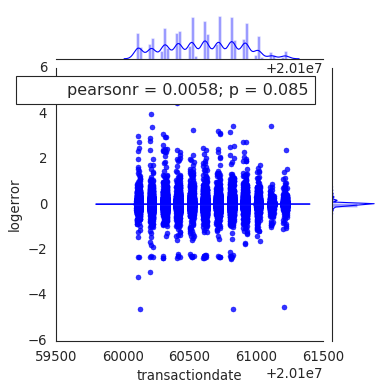

In [290]:
for i, col in enumerate(['calculatedbathnbr',
 'fullbathcnt',
 'propertylandusetypeid',
 'structuretaxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'transactiondate']):
    with sns.axes_style('white'):
        plot_number = i + 1
        series = usable_df[col]
        j = sns.jointplot(usable_df[col], 'logerror', usable_df, kind='reg', height=5)
        j.annotate(stats.pearsonr)

In [301]:
usable_df = usable_df.drop_duplicates(subset=['parcelid'])

In [302]:
usable_df.shape

(88886, 9)

In [299]:
non_multi_with_sqft_with_zip_all_taxvalue.shape

(85551, 8)

In [303]:
# Merging usable_db to previous db.
final_db = pd.merge(non_multi_with_sqft_with_zip_all_taxvalue, usable_df, on=['parcelid'], how='left')
final_db.shape

(85551, 16)

In [304]:
final_db.isnull().sum()

parcelid                         0
bathroomcnt                      0
bedroomcnt                       0
calculatedfinishedsquarefeet     0
regionidzip                      0
yearbuilt                        0
taxvaluedollarcnt                0
logerror_x                       0
calculatedbathnbr               91
fullbathcnt                     91
propertylandusetypeid           91
structuretaxvaluedollarcnt      91
landtaxvaluedollarcnt           91
taxamount                       91
logerror_y                      91
transactiondate                 91
dtype: int64

In [305]:
final_db = final_db.dropna()

In [306]:
final_db.isnull().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
regionidzip                     0
yearbuilt                       0
taxvaluedollarcnt               0
logerror_x                      0
calculatedbathnbr               0
fullbathcnt                     0
propertylandusetypeid           0
structuretaxvaluedollarcnt      0
landtaxvaluedollarcnt           0
taxamount                       0
logerror_y                      0
transactiondate                 0
dtype: int64

In [307]:
final_db.describe()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,regionidzip,yearbuilt,taxvaluedollarcnt,logerror_x,calculatedbathnbr,fullbathcnt,propertylandusetypeid,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror_y,transactiondate
count,8.546000e+04,85460.000000,85460.000000,85460.000000,85460.000000,85460.000000,8.546000e+04,85460.000000,85460.000000,85460.000000,85460.000000,8.546000e+04,8.546000e+04,85460.000000,85460.000000,8.546000e+04
mean,1.301030e+07,2.275960,3.007524,1744.143845,96554.909642,1969.703698,4.587007e+05,0.011675,2.275960,2.205149,262.540288,1.806429e+05,2.780577e+05,5963.406024,0.011570,2.016060e+07
std,2.548725e+06,0.938668,1.004339,909.524019,409.578286,23.096861,5.561342e+05,0.153818,0.938668,0.921886,2.457208,2.099472e+05,3.996919e+05,6817.653663,0.153831,2.804186e+02
min,1.071174e+07,1.000000,0.000000,199.000000,95982.000000,1885.000000,7.704000e+03,-4.605000,1.000000,1.000000,246.000000,1.019000e+03,1.319000e+03,96.740000,-4.605000,2.016010e+07
25%,1.154207e+07,2.000000,2.000000,1170.000000,96208.000000,1954.000000,2.000000e+05,-0.024300,2.000000,2.000000,261.000000,8.162400e+04,8.196800e+04,2868.362500,-0.024300,2.016041e+07
50%,1.259445e+07,2.000000,3.000000,1516.000000,96403.000000,1971.000000,3.440795e+05,0.006000,2.000000,2.000000,261.000000,1.321885e+05,1.937480e+05,4533.935000,0.006000,2.016061e+07
75%,1.425707e+07,3.000000,4.000000,2054.000000,96987.000000,1987.000000,5.408325e+05,0.037300,3.000000,3.000000,266.000000,2.107015e+05,3.460000e+05,6877.845000,0.037300,2.016082e+07
max,1.629608e+08,15.000000,16.000000,20013.000000,97344.000000,2015.000000,2.775000e+07,4.737000,15.000000,15.000000,275.000000,9.948100e+06,2.450000e+07,321936.090000,4.737000,2.016123e+07


In [309]:
final_db.head(30)

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,regionidzip,yearbuilt,taxvaluedollarcnt,logerror_x,calculatedbathnbr,fullbathcnt,propertylandusetypeid,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror_y,transactiondate
0,17073783,2.5,3.0,1264.0,97081.0,1986.0,191811.0,0.0953,2.5,2.0,265.0,115087.0,76724.0,2015.06,0.0953,20160127.0
1,17088994,1.0,2.0,777.0,97083.0,1990.0,239679.0,0.0198,1.0,1.0,266.0,143809.0,95870.0,2581.30,0.0198,20160330.0
2,17100444,2.0,3.0,1101.0,97113.0,1956.0,47853.0,0.0060,2.0,2.0,261.0,33619.0,14234.0,591.64,0.0060,20160527.0
3,17102429,1.5,2.0,1554.0,97113.0,1965.0,62914.0,-0.0566,1.5,1.0,261.0,45609.0,17305.0,682.78,-0.0566,20160607.0
4,17109604,2.5,4.0,2415.0,97084.0,1984.0,554000.0,0.0573,2.5,2.0,261.0,277000.0,277000.0,5886.92,0.0573,20160808.0
5,17125829,2.5,4.0,2882.0,97089.0,1980.0,289609.0,0.0564,2.5,2.0,261.0,222070.0,67539.0,3110.44,0.0564,20160826.0
6,17132911,2.0,3.0,1772.0,97089.0,1978.0,526000.0,0.0315,2.0,2.0,261.0,185000.0,341000.0,5632.20,0.0315,20160708.0
7,17134926,2.5,5.0,2632.0,97089.0,1971.0,571086.0,0.0257,2.5,2.0,261.0,342611.0,228475.0,6109.94,0.0257,20160511.0
8,17139988,2.0,3.0,1292.0,97091.0,1979.0,462594.0,0.0020,2.0,2.0,261.0,231297.0,231297.0,5026.40,0.0020,20160615.0
9,17167359,1.0,3.0,1385.0,97104.0,1950.0,268502.0,-0.0576,1.0,1.0,261.0,134251.0,134251.0,3217.06,-0.0576,20160527.0


In [310]:
final_db = final_db.drop('logerror_y', axis=1)

In [313]:
final_db = final_db.rename(index=str, columns={"logerror_x": "logerror"})

In [317]:
final_db.dtypes

parcelid                          int64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
regionidzip                     float64
yearbuilt                       float64
taxvaluedollarcnt               float64
logerror                        float64
calculatedbathnbr               float64
fullbathcnt                     float64
propertylandusetypeid           float64
structuretaxvaluedollarcnt      float64
landtaxvaluedollarcnt           float64
taxamount                       float64
transactiondate                 float64
dtype: object

In [338]:
# Will a price per sqft column help?
final_db['pricepersqft'] = final_db.apply(lambda row: row.taxvaluedollarcnt / row.calculatedfinishedsquarefeet, axis=1)
final_db.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,regionidzip,yearbuilt,taxvaluedollarcnt,logerror,calculatedbathnbr,fullbathcnt,propertylandusetypeid,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,transactiondate,pricepersqft
0,17073783,2.5,3.0,1264.0,97081.0,1986.0,191811.0,0.0953,2.5,2.0,265.0,115087.0,76724.0,2015.06,20160127.0,151.749209
1,17088994,1.0,2.0,777.0,97083.0,1990.0,239679.0,0.0198,1.0,1.0,266.0,143809.0,95870.0,2581.30,20160330.0,308.467181
2,17100444,2.0,3.0,1101.0,97113.0,1956.0,47853.0,0.0060,2.0,2.0,261.0,33619.0,14234.0,591.64,20160527.0,43.463215
3,17102429,1.5,2.0,1554.0,97113.0,1965.0,62914.0,-0.0566,1.5,1.0,261.0,45609.0,17305.0,682.78,20160607.0,40.485199
4,17109604,2.5,4.0,2415.0,97084.0,1984.0,554000.0,0.0573,2.5,2.0,261.0,277000.0,277000.0,5886.92,20160808.0,229.399586


In [339]:
final_db.dtypes

parcelid                          int64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
regionidzip                     float64
yearbuilt                       float64
taxvaluedollarcnt               float64
logerror                        float64
calculatedbathnbr               float64
fullbathcnt                     float64
propertylandusetypeid           float64
structuretaxvaluedollarcnt      float64
landtaxvaluedollarcnt           float64
taxamount                       float64
transactiondate                 float64
pricepersqft                    float64
dtype: object

In [340]:
list(final_db)

['parcelid',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'regionidzip',
 'yearbuilt',
 'taxvaluedollarcnt',
 'logerror',
 'calculatedbathnbr',
 'fullbathcnt',
 'propertylandusetypeid',
 'structuretaxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'transactiondate',
 'pricepersqft']

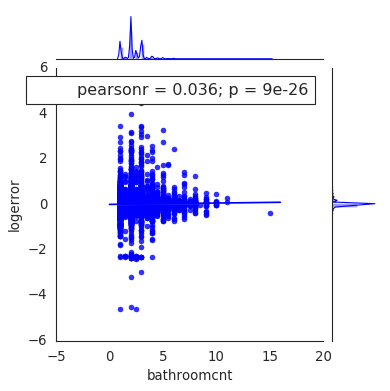

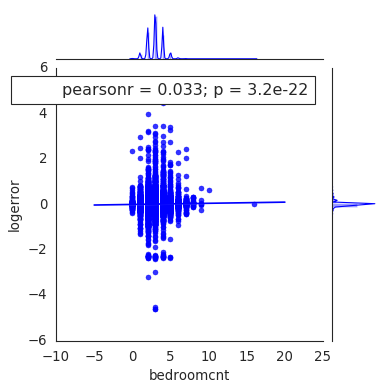

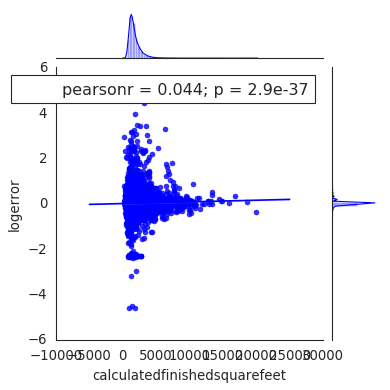

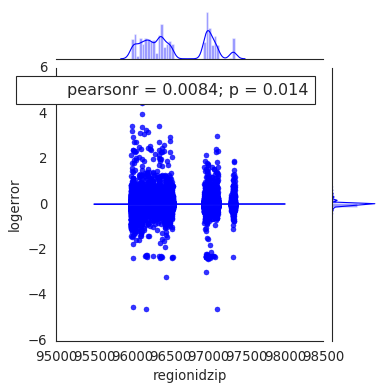

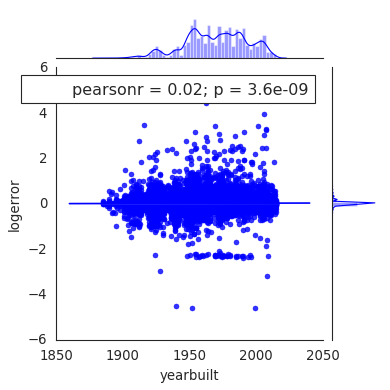

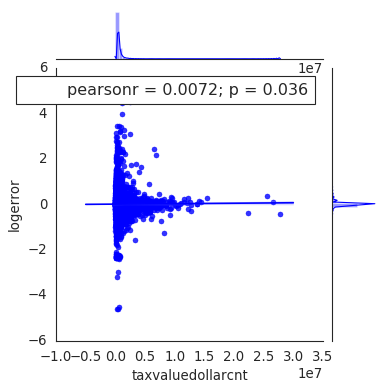

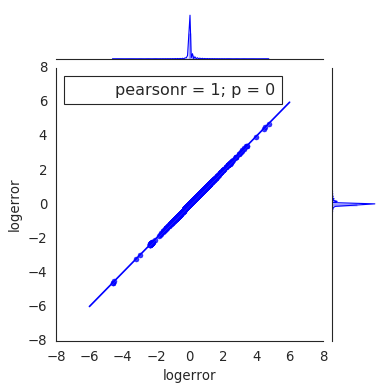

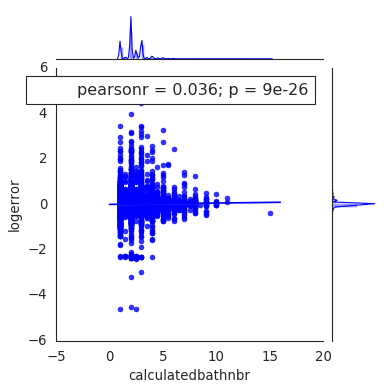

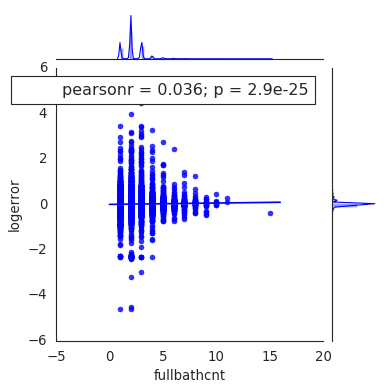

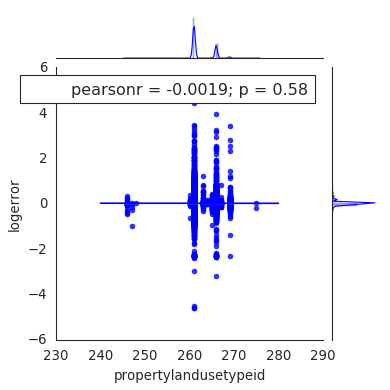

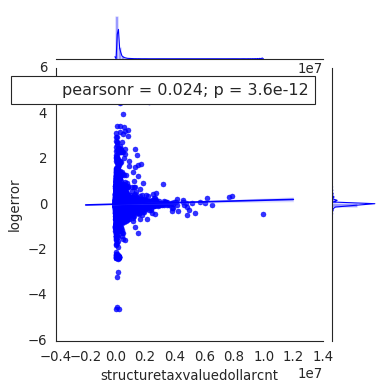

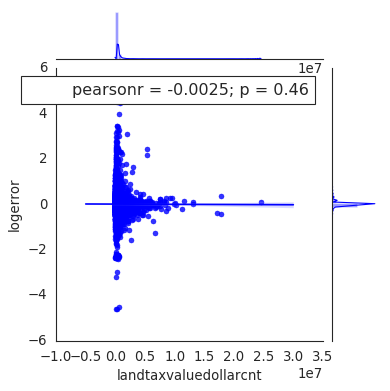

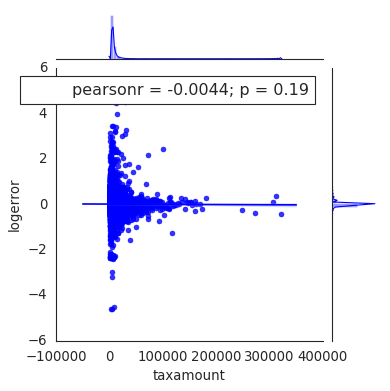

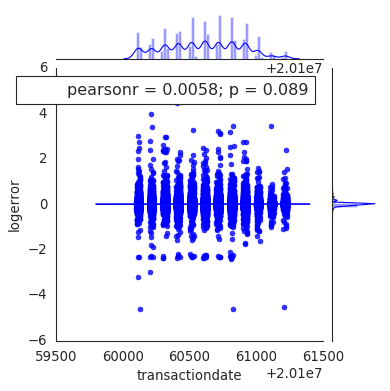

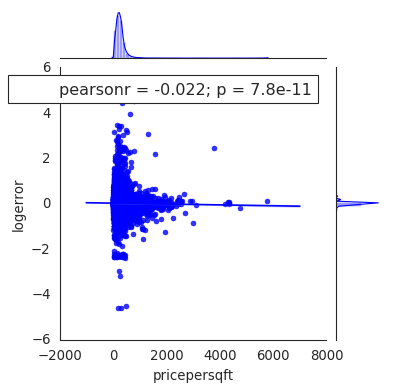

In [342]:
for i, col in enumerate(['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'regionidzip',
 'yearbuilt',
 'taxvaluedollarcnt',
 'logerror',
 'calculatedbathnbr',
 'fullbathcnt',
 'propertylandusetypeid',
 'structuretaxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'transactiondate',
 'pricepersqft']):
    with sns.axes_style('white'):
        plot_number = i + 1
        series = final_db[col]
        j = sns.jointplot(final_db[col], 'logerror', final_db, kind='reg', height=5)
        j.annotate(stats.pearsonr)

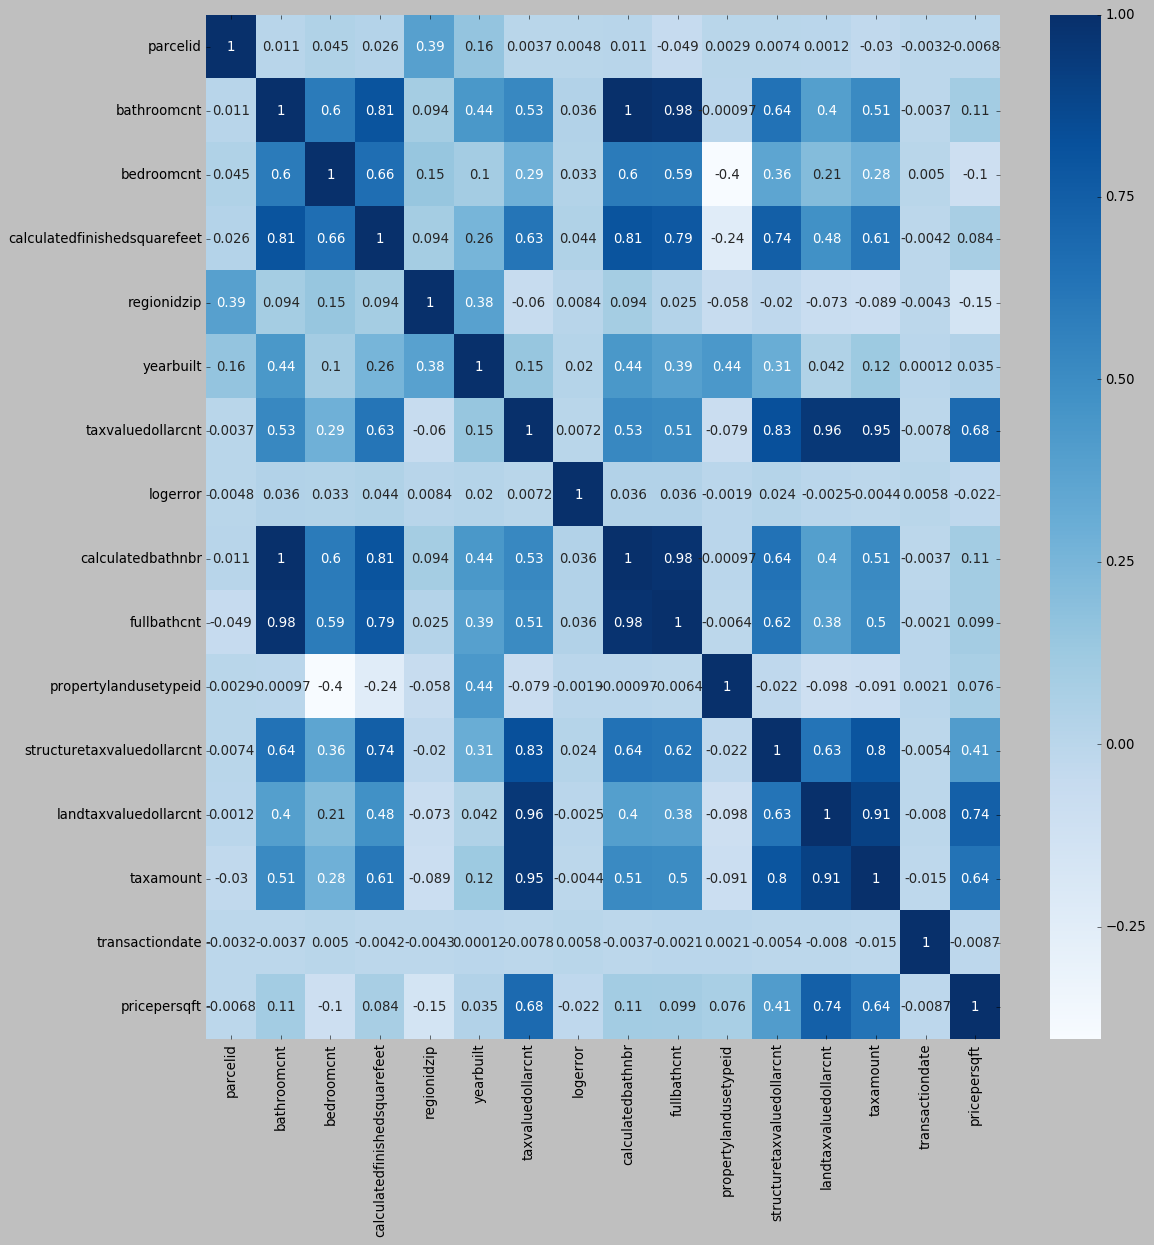

In [343]:
plt.figure(figsize=(16, 16))
sns.heatmap(final_db.corr(), cmap='Blues', annot=True)

In [351]:
X1f = final_db[['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'regionidzip',
 'yearbuilt',
 'taxvaluedollarcnt',
 'calculatedbathnbr',
 'fullbathcnt',
 'propertylandusetypeid',
 'structuretaxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'transactiondate',
 'pricepersqft']]
y1f = final_db[['logerror']]
X1f_train, X1f_test, y1f_train, y1f_test = train_test_split(X1f, y1f, train_size=.80, random_state=0)
train1f = pd.concat([X1f_train, y1f_train], axis=1)
print("Train columns:  %s" % list(train1f.columns))
print("Train dimensions (rows, columns):", train1f.shape)
test1f = pd.concat([X1f_test, y1f_test], axis=1)
print("Test columns:  %s" % list(test1f.columns))
print("Test dimensions (rows, columns):", test1f.shape)
if X1f_train.shape[0] == y1f_train.shape[0]:
    print("X & y train rows ARE equal")
else:
    print("X & y train rows ARE NOT equal")


if X1f_test.shape[0] == y1f_test.shape[0]:
    print("X & y test rows ARE equal")
else:
    print("X & y test rows ARE NOT equal")

if train1f.shape[1] == test1f.shape[1]:
    print("Number of columns in train & test ARE equal")
else:
    print("Number of columns in train & test ARE NOT equal")

train1f_split = train1f.shape[0] / (train1f.shape[0] + test1f.shape[0])
test1f_split = test1f.shape[0] / (train1f.shape[0] + test1f.shape[0])

print("Train Split: %.2f" % train1f_split)
print("Test Split: %.2f" % test1f_split)
print('-----')

print('PearsonR for train1f:')
print('  '+ str([[column, pearsonr(train1f[column], train1f.logerror)] for column in X1f_train] ))
print('-----')

ols_model1f = sm.OLS(y1f_train, X1f_train)
fit1f = ols_model1f.fit()
print(fit1f.summary())
print('-----')

lm1f = LinearRegression()
lm1f.fit(X1f_train[['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'regionidzip',
 'yearbuilt',
 'taxvaluedollarcnt',
 'calculatedbathnbr',
 'fullbathcnt',
 'propertylandusetypeid',
 'structuretaxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'transactiondate',
 'pricepersqft']], y1f_train)
lm1f_y_intercept = lm1f.intercept_
print('lm1f y_intercept for train:')
print(lm1f_y_intercept)
lm1f_coefficients = lm1f.coef_
print('lm1f_coefficients for train: ')
print(lm1f_coefficients)

pred_lm1f_train = lm1f.predict(X1f_train)

sum_of_lm1f_pred_residuals_train = abs(pred_lm1f_train).sum()
print('Sum of predicted residuals for lm1f on train sample: ')
print(sum_of_lm1f_pred_residuals_train)
mse_lm1f_train = mean_squared_error(y1f_train, pred_lm1f_train)
print("Mean squared error for train set: %.6f" % mse_lm1f_train)

pred_lm1f = lm1f.predict(X1f_test)

sum_of_lm1f_pred_residuals = abs(pred_lm1f).sum()
print('Sum of predicted residuals for lm1f on test sample: ')
print(sum_of_lm1f_pred_residuals)
mse_lm1f = mean_squared_error(y1f_test, pred_lm1f)
print("Mean squared error: %.6f" % mse_lm1f)

Train columns:  ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'regionidzip', 'yearbuilt', 'taxvaluedollarcnt', 'calculatedbathnbr', 'fullbathcnt', 'propertylandusetypeid', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'transactiondate', 'pricepersqft', 'logerror']
Train dimensions (rows, columns): (68368, 15)
Test columns:  ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'regionidzip', 'yearbuilt', 'taxvaluedollarcnt', 'calculatedbathnbr', 'fullbathcnt', 'propertylandusetypeid', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'transactiondate', 'pricepersqft', 'logerror']
Test dimensions (rows, columns): (17092, 15)
X & y train rows ARE equal
X & y test rows ARE equal
Number of columns in train & test ARE equal
Train Split: 0.80
Test Split: 0.20
-----
PearsonR for train1f:
  [['bathroomcnt', (0.03342856769096459, 2.271151450866034e-18)], ['bedroomcnt', (0.0340284837834275, 5.587895586863663e-19)], ['calculatedfinis

In [352]:
X2f = final_db[['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'calculatedbathnbr',
 'fullbathcnt',
 'pricepersqft']]
y2f = final_db[['logerror']]
X2f_train, X2f_test, y2f_train, y2f_test = train_test_split(X2f, y2f, train_size=.80, random_state=0)
train2f = pd.concat([X2f_train, y2f_train], axis=1)
print("Train columns:  %s" % list(train2f.columns))
print("Train dimensions (rows, columns):", train2f.shape)
test2f = pd.concat([X2f_test, y2f_test], axis=1)
print("Test columns:  %s" % list(test2f.columns))
print("Test dimensions (rows, columns):", test2f.shape)
if X2f_train.shape[0] == y2f_train.shape[0]:
    print("X & y train rows ARE equal")
else:
    print("X & y train rows ARE NOT equal")


if X2f_test.shape[0] == y2f_test.shape[0]:
    print("X & y test rows ARE equal")
else:
    print("X & y test rows ARE NOT equal")

if train2f.shape[1] == test2f.shape[1]:
    print("Number of columns in train & test ARE equal")
else:
    print("Number of columns in train & test ARE NOT equal")

train2f_split = train2f.shape[0] / (train2f.shape[0] + test2f.shape[0])
test2f_split = test2f.shape[0] / (train2f.shape[0] + test2f.shape[0])

print("Train Split: %.2f" % train2f_split)
print("Test Split: %.2f" % test2f_split)
print('-----')

print('PearsonR for train2f:')
print('  '+ str([[column, pearsonr(train2f[column], train2f.logerror)] for column in X2f_train] ))
print('-----')

ols_model2f = sm.OLS(y2f_train, X2f_train)
fit2f = ols_model2f.fit()
print(fit2f.summary())
print('-----')

lm2f = LinearRegression()
lm2f.fit(X2f_train[['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'calculatedbathnbr',
 'fullbathcnt',
 'pricepersqft']], y2f_train)
lm2f_y_intercept = lm2f.intercept_
print('lm2f y_intercept for train:')
print(lm2f_y_intercept)
lm2f_coefficients = lm2f.coef_
print('lm2f_coefficients for train: ')
print(lm2f_coefficients)

pred_lm2f_train = lm2f.predict(X2f_train)

sum_of_lm2f_pred_residuals_train = abs(pred_lm2f_train).sum()
print('Sum of predicted residuals for lm2f on train sample: ')
print(sum_of_lm2f_pred_residuals_train)
mse_lm2f_train = mean_squared_error(y2f_train, pred_lm2f_train)
print("Mean squared error for train set: %.6f" % mse_lm2f_train)

pred_lm2f = lm2f.predict(X2f_test)

sum_of_lm2f_pred_residuals = abs(pred_lm2f).sum()
print('Sum of predicted residuals for lm2f on test sample: ')
print(sum_of_lm2f_pred_residuals)
mse_lm2f = mean_squared_error(y2f_test, pred_lm2f)
print("Mean squared error: %.6f" % mse_lm2f)

Train columns:  ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'calculatedbathnbr', 'fullbathcnt', 'pricepersqft', 'logerror']
Train dimensions (rows, columns): (68368, 7)
Test columns:  ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'calculatedbathnbr', 'fullbathcnt', 'pricepersqft', 'logerror']
Test dimensions (rows, columns): (17092, 7)
X & y train rows ARE equal
X & y test rows ARE equal
Number of columns in train & test ARE equal
Train Split: 0.80
Test Split: 0.20
-----
PearsonR for train2f:
  [['bathroomcnt', (0.03342856769096459, 2.271151450866034e-18)], ['bedroomcnt', (0.0340284837834275, 5.587895586863663e-19)], ['calculatedfinishedsquarefeet', (0.042812263841041295, 4.115702573007464e-29)], ['calculatedbathnbr', (0.03342856769096459, 2.271151450866034e-18)], ['fullbathcnt', (0.03334717214413793, 2.741938372232556e-18)], ['pricepersqft', (-0.02796145955262714, 2.6230371337719614e-13)]]
-----
                            OLS Regression Results      

In [353]:
X3f = final_db[['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'calculatedbathnbr',
 'fullbathcnt']]
y3f = final_db[['logerror']]
X3f_train, X3f_test, y3f_train, y3f_test = train_test_split(X3f, y3f, train_size=.80, random_state=0)
train3f = pd.concat([X3f_train, y3f_train], axis=1)
print("Train columns:  %s" % list(train3f.columns))
print("Train dimensions (rows, columns):", train3f.shape)
test3f = pd.concat([X3f_test, y3f_test], axis=1)
print("Test columns:  %s" % list(test3f.columns))
print("Test dimensions (rows, columns):", test3f.shape)
if X3f_train.shape[0] == y3f_train.shape[0]:
    print("X & y train rows ARE equal")
else:
    print("X & y train rows ARE NOT equal")


if X3f_test.shape[0] == y3f_test.shape[0]:
    print("X & y test rows ARE equal")
else:
    print("X & y test rows ARE NOT equal")

if train3f.shape[1] == test3f.shape[1]:
    print("Number of columns in train & test ARE equal")
else:
    print("Number of columns in train & test ARE NOT equal")

train3f_split = train3f.shape[0] / (train3f.shape[0] + test3f.shape[0])
test3f_split = test3f.shape[0] / (train3f.shape[0] + test3f.shape[0])

print("Train Split: %.2f" % train3f_split)
print("Test Split: %.2f" % test3f_split)
print('-----')

print('PearsonR for train3f:')
print('  '+ str([[column, pearsonr(train3f[column], train3f.logerror)] for column in X3f_train] ))
print('-----')

ols_model3f = sm.OLS(y3f_train, X3f_train)
fit3f = ols_model3f.fit()
print(fit3f.summary())
print('-----')

lm3f = LinearRegression()
lm3f.fit(X3f_train[['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'calculatedbathnbr',
 'fullbathcnt']], y3f_train)
lm3f_y_intercept = lm3f.intercept_
print('lm3f y_intercept for train:')
print(lm3f_y_intercept)
lm3f_coefficients = lm3f.coef_
print('lm3f_coefficients for train: ')
print(lm3f_coefficients)

pred_lm3f_train = lm3f.predict(X3f_train)

sum_of_lm3f_pred_residuals_train = abs(pred_lm3f_train).sum()
print('Sum of predicted residuals for lm3f on train sample: ')
print(sum_of_lm3f_pred_residuals_train)
mse_lm3f_train = mean_squared_error(y3f_train, pred_lm3f_train)
print("Mean squared error for train set: %.6f" % mse_lm3f_train)

pred_lm3f = lm3f.predict(X3f_test)

sum_of_lm3f_pred_residuals = abs(pred_lm3f).sum()
print('Sum of predicted residuals for lm3f on test sample: ')
print(sum_of_lm3f_pred_residuals)
mse_lm3f = mean_squared_error(y3f_test, pred_lm3f)
print("Mean squared error: %.6f" % mse_lm3f)

Train columns:  ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'calculatedbathnbr', 'fullbathcnt', 'logerror']
Train dimensions (rows, columns): (68368, 6)
Test columns:  ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'calculatedbathnbr', 'fullbathcnt', 'logerror']
Test dimensions (rows, columns): (17092, 6)
X & y train rows ARE equal
X & y test rows ARE equal
Number of columns in train & test ARE equal
Train Split: 0.80
Test Split: 0.20
-----
PearsonR for train3f:
  [['bathroomcnt', (0.03342856769096459, 2.271151450866034e-18)], ['bedroomcnt', (0.0340284837834275, 5.587895586863663e-19)], ['calculatedfinishedsquarefeet', (0.042812263841041295, 4.115702573007464e-29)], ['calculatedbathnbr', (0.03342856769096459, 2.271151450866034e-18)], ['fullbathcnt', (0.03334717214413793, 2.741938372232556e-18)]]
-----
                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.

Text(0, 0.5, 'Residuals')

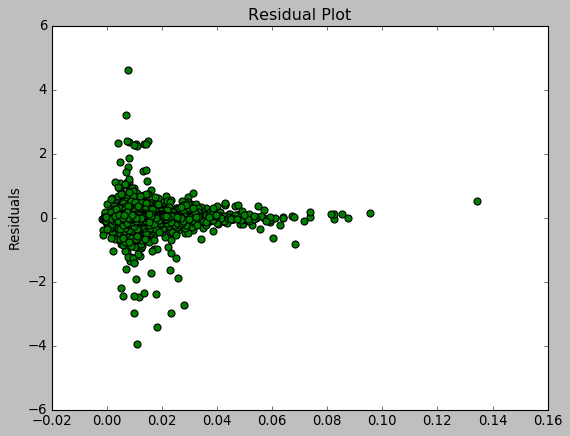

In [358]:
plt.scatter(pred_lm3f, pred_lm3f-y3f_test, c='g', s=40)
plt.title('Residual Plot')
plt.ylabel('Residuals')


In [346]:
#zillow_multi_home = test[test.unitcnt >= 2]
no_studio_final_db = final_db[final_db.bedroomcnt >= 1]
no_studio_final_db.shape

(85236, 16)

In [347]:
# final_db['pricepersqft'] = final_db.apply(lambda row: row.taxvaluedollarcnt / row.calculatedfinishedsquarefeet, axis=1)
# final_db.head()
no_studio_final_db['priceperbedroom'] = no_studio_final_db.apply(lambda row: row.taxvaluedollarcnt / row.bedroomcnt, axis=1)
no_studio_final_db.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,regionidzip,yearbuilt,taxvaluedollarcnt,logerror,calculatedbathnbr,fullbathcnt,propertylandusetypeid,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,transactiondate,pricepersqft,priceperbedroom
0,17073783,2.5,3.0,1264.0,97081.0,1986.0,191811.0,0.0953,2.5,2.0,265.0,115087.0,76724.0,2015.06,20160127.0,151.749209,63937.0
1,17088994,1.0,2.0,777.0,97083.0,1990.0,239679.0,0.0198,1.0,1.0,266.0,143809.0,95870.0,2581.30,20160330.0,308.467181,119839.5
2,17100444,2.0,3.0,1101.0,97113.0,1956.0,47853.0,0.0060,2.0,2.0,261.0,33619.0,14234.0,591.64,20160527.0,43.463215,15951.0
3,17102429,1.5,2.0,1554.0,97113.0,1965.0,62914.0,-0.0566,1.5,1.0,261.0,45609.0,17305.0,682.78,20160607.0,40.485199,31457.0
4,17109604,2.5,4.0,2415.0,97084.0,1984.0,554000.0,0.0573,2.5,2.0,261.0,277000.0,277000.0,5886.92,20160808.0,229.399586,138500.0


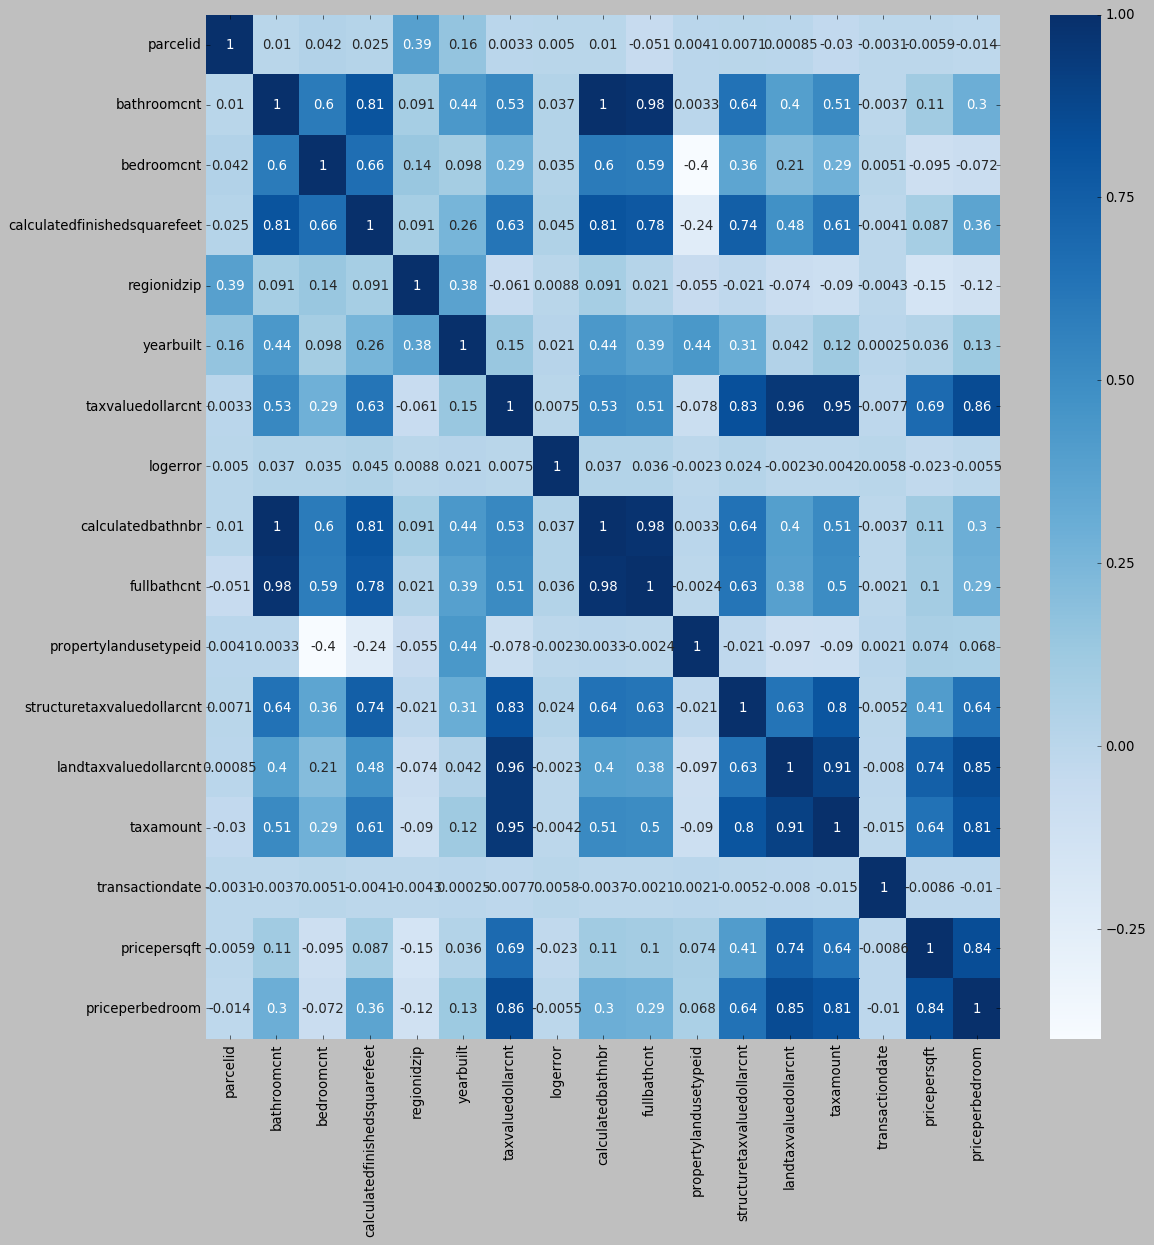

In [348]:
plt.figure(figsize=(16, 16))
sns.heatmap(no_studio_final_db.corr(), cmap='Blues', annot=True)